In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=150,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3
import sys
sys.path.append("/home/qukun/xuhao/workspace/Utils")
import sc_plot
from sc_process import grouped_obs_mean
from sc_plot import plot_proportion

In [ ]:
# cx_pbmc_all = sc.read_h5ad('cx_pbmc_all.h5ad')

# cx_pbmc_all.obs.loc[[len(s) > 4 for s in cx_pbmc_all.obs['sample']],'tissue'] = 'SG'
# cx_pbmc_all.obs.loc[[len(s) <= 4 for s in cx_pbmc_all.obs['sample']],'tissue'] = 'PBMC'

# cx_pbmc_all.obs.loc[:,'celltype_major'] = np.array(cx_pbmc_all.obs.loc[:,'celltype_major'])

# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['B_BANK1', 'B_CD83', 'B_IGHD', 'B_VPREB3']),'celltype_major'] = 'B'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['Mac_CLEC4A','Mac_SELENOP','Mono_CDKN1C', 'Mono_PID1', 'Mono_S100A8','Mono_S100A9']),'celltype_major'] = 'Mac/mo'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['NK_SPON2']),'celltype_major'] = 'NK'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['Mast']),'celltype_major'] = 'Mast'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['MAIT']),'celltype_major'] = 'MAIT'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['Plasma_HSPA1B', 'Plasma_IGHA1', 'Plasma_IGHG1', 'Plasma_IGKV2D-28']),'celltype_major'] = 'Plasma'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['T_CD4_ADTRP', 'T_CD4_CXCL13','T_CD4_FOXP3', 'T_CD4_IL10', 'T_CD4_IL7R', 'T_CD4_LAMP3','T_CD4_PASK', 'T_CD4_TNFSFR4']),'celltype_major'] = 'CD4_T'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['T_CD8_CCL5', 'T_CD8_GZMH','T_CD8_GZMK', 'T_CD8_ITGA1', 'T_CD8_KIR2DL4', 'T_CD8_KLRC2','T_CD8_NELL2', 'T_CD8_XCL1']),'celltype_major'] = 'CD8_T'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['T_MKI67']),'celltype_major'] = 'Cycling_T'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['T_TRGC1_TRDC']),'celltype_major'] = 'gdT'
# cx_pbmc_all.obs.loc[cx_pbmc_all.obs.celltype_minor.isin(['cDC']),'celltype_major'] = 'cDC'

# cx_pbmc_all = cx_pbmc_all[cx_pbmc_all.obs.loc[:,'celltype_major'] != 'Unknown'].copy()

# cx_pbmc_all.write_h5ad('cx_pbmc_all.h5ad')

In [2]:
cx_pbmc_all = sc.read_h5ad('cx_pbmc_all.h5ad')

In [8]:
pbmc_raw  = cx_pbmc_all[cx_pbmc_all.obs['tissue'] == 'PBMC'].raw.to_adata()

In [19]:
pbmc_nofilter = sc.read_h5ad('pbmc_cellbender_raw.h5ad')

In [21]:
pbmc_nofilter

AnnData object with n_obs × n_vars = 70847 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt'
    var: 'features'

In [22]:
for s in np.unique(pbmc_nofilter.obs['orig.ident']):
    print((pbmc_nofilter.obs['orig.ident'] == s).sum())

12129
10746
9700
4860
6835
4406
11466
10705


In [25]:
pbmc_info = pbmc_nofilter.obs[['orig.ident','nCount_RNA','nFeature_RNA','percent.mt']].groupby('orig.ident').median()

In [26]:
pbmc_info['cell_number'] = [12129,10746,9700,4860,6835,4406,11466,10705]

In [28]:
pbmc_info.to_csv('cx_pbmc_immune_results/pbmc_sample_info.csv')

In [35]:
pbmc_raw_df = pbmc_raw.to_df()

In [38]:
pbmc_raw_df = pbmc_raw_df.loc[:,pbmc_raw_df.sum(0)!=0]

In [39]:
pbmc_raw_df.to_csv('pbmc_raw_counts.tsv',sep='\t')

In [4]:
def get_all_cluster_degs(ad,cluster_key,degs_key=None,log2fc_min=0.25,pval_cutoff=0.001,pts_min=0.1,out_pts_max=0.5,n_top=None):
    if degs_key is None:
        degs_key = 'rank_genes_groups'
    df_list = []
    if type(ad.obs[cluster_key]) == pd.core.series.Series:
        cluster_order = ad.obs[cluster_key].cat.categories
    else:
        cluster_order = np.unique(ad.obs[cluster_key])
    for c in cluster_order:
        df = sc.get.rank_genes_groups_df(ad,group=str(c),key=degs_key,log2fc_min=log2fc_min,pval_cutoff=pval_cutoff)
        df = df.sort_values(by='logfoldchanges',ascending=False)
#         df = df.sort_values(by='scores',ascending=False)
        df = df[df['pct_nz_group'] > pts_min]
        df = df[df['pct_nz_reference'] < out_pts_max]
        df['cluster'] = c
        if n_top is not None:
            df = df.iloc[:n_top,:]
        df_list.append(df)
    df_all = pd.concat(df_list,axis=0)
    df_all = df_all.reset_index(drop=True)
    return df_all

# RPCA pc20 neighbor50

In [2]:
cx_pbmc_immune = sc.read_h5ad('../scripts/CX_20211030/s14_cx_pbmc_immune_inte_seurat_rpca_pc20_neighbor50.h5ad')

cx_pbmc_immune.raw.var.index = cx_pbmc_immune.raw.var['_index']

cx_pbmc_immune.obs['seurat_clusters'] = pd.Categorical(cx_pbmc_immune.obs['seurat_clusters'])

cx_pbmc_immune.obs.loc[cx_pbmc_immune.obs['sample'].isin(['HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5','HC_1','HC_2','HC_3']),'cli_state'] = 'HC'
cx_pbmc_immune.obs.loc[cx_pbmc_immune.obs['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11','XN_1','XN_2','XN_3','XN_4','XN_5']),'cli_state'] = 'SjS'
cx_pbmc_immune.obs['cli_state'] = pd.Categorical(cx_pbmc_immune.obs['cli_state'])

In [5]:
cx_pbmc_immune.uns['tissue_colors'] = [matplotlib.colors.to_hex(c) for c in sns.color_palette('Dark2',n_colors=5)[3:]]

In [15]:
sc.tl.rank_genes_groups(cx_pbmc_immune,use_raw=False,groupby='seurat_clusters',method='wilcoxon',pts=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:41)


In [9]:
top10_markers = get_all_cluster_degs(cx_pbmc_immune,cluster_key='seurat_clusters',n_top=10)
top5_markers = get_all_cluster_degs(cx_pbmc_immune,cluster_key='seurat_clusters',n_top=5)
top2_markers = get_all_cluster_degs(cx_pbmc_immune,cluster_key='seurat_clusters',n_top=2)

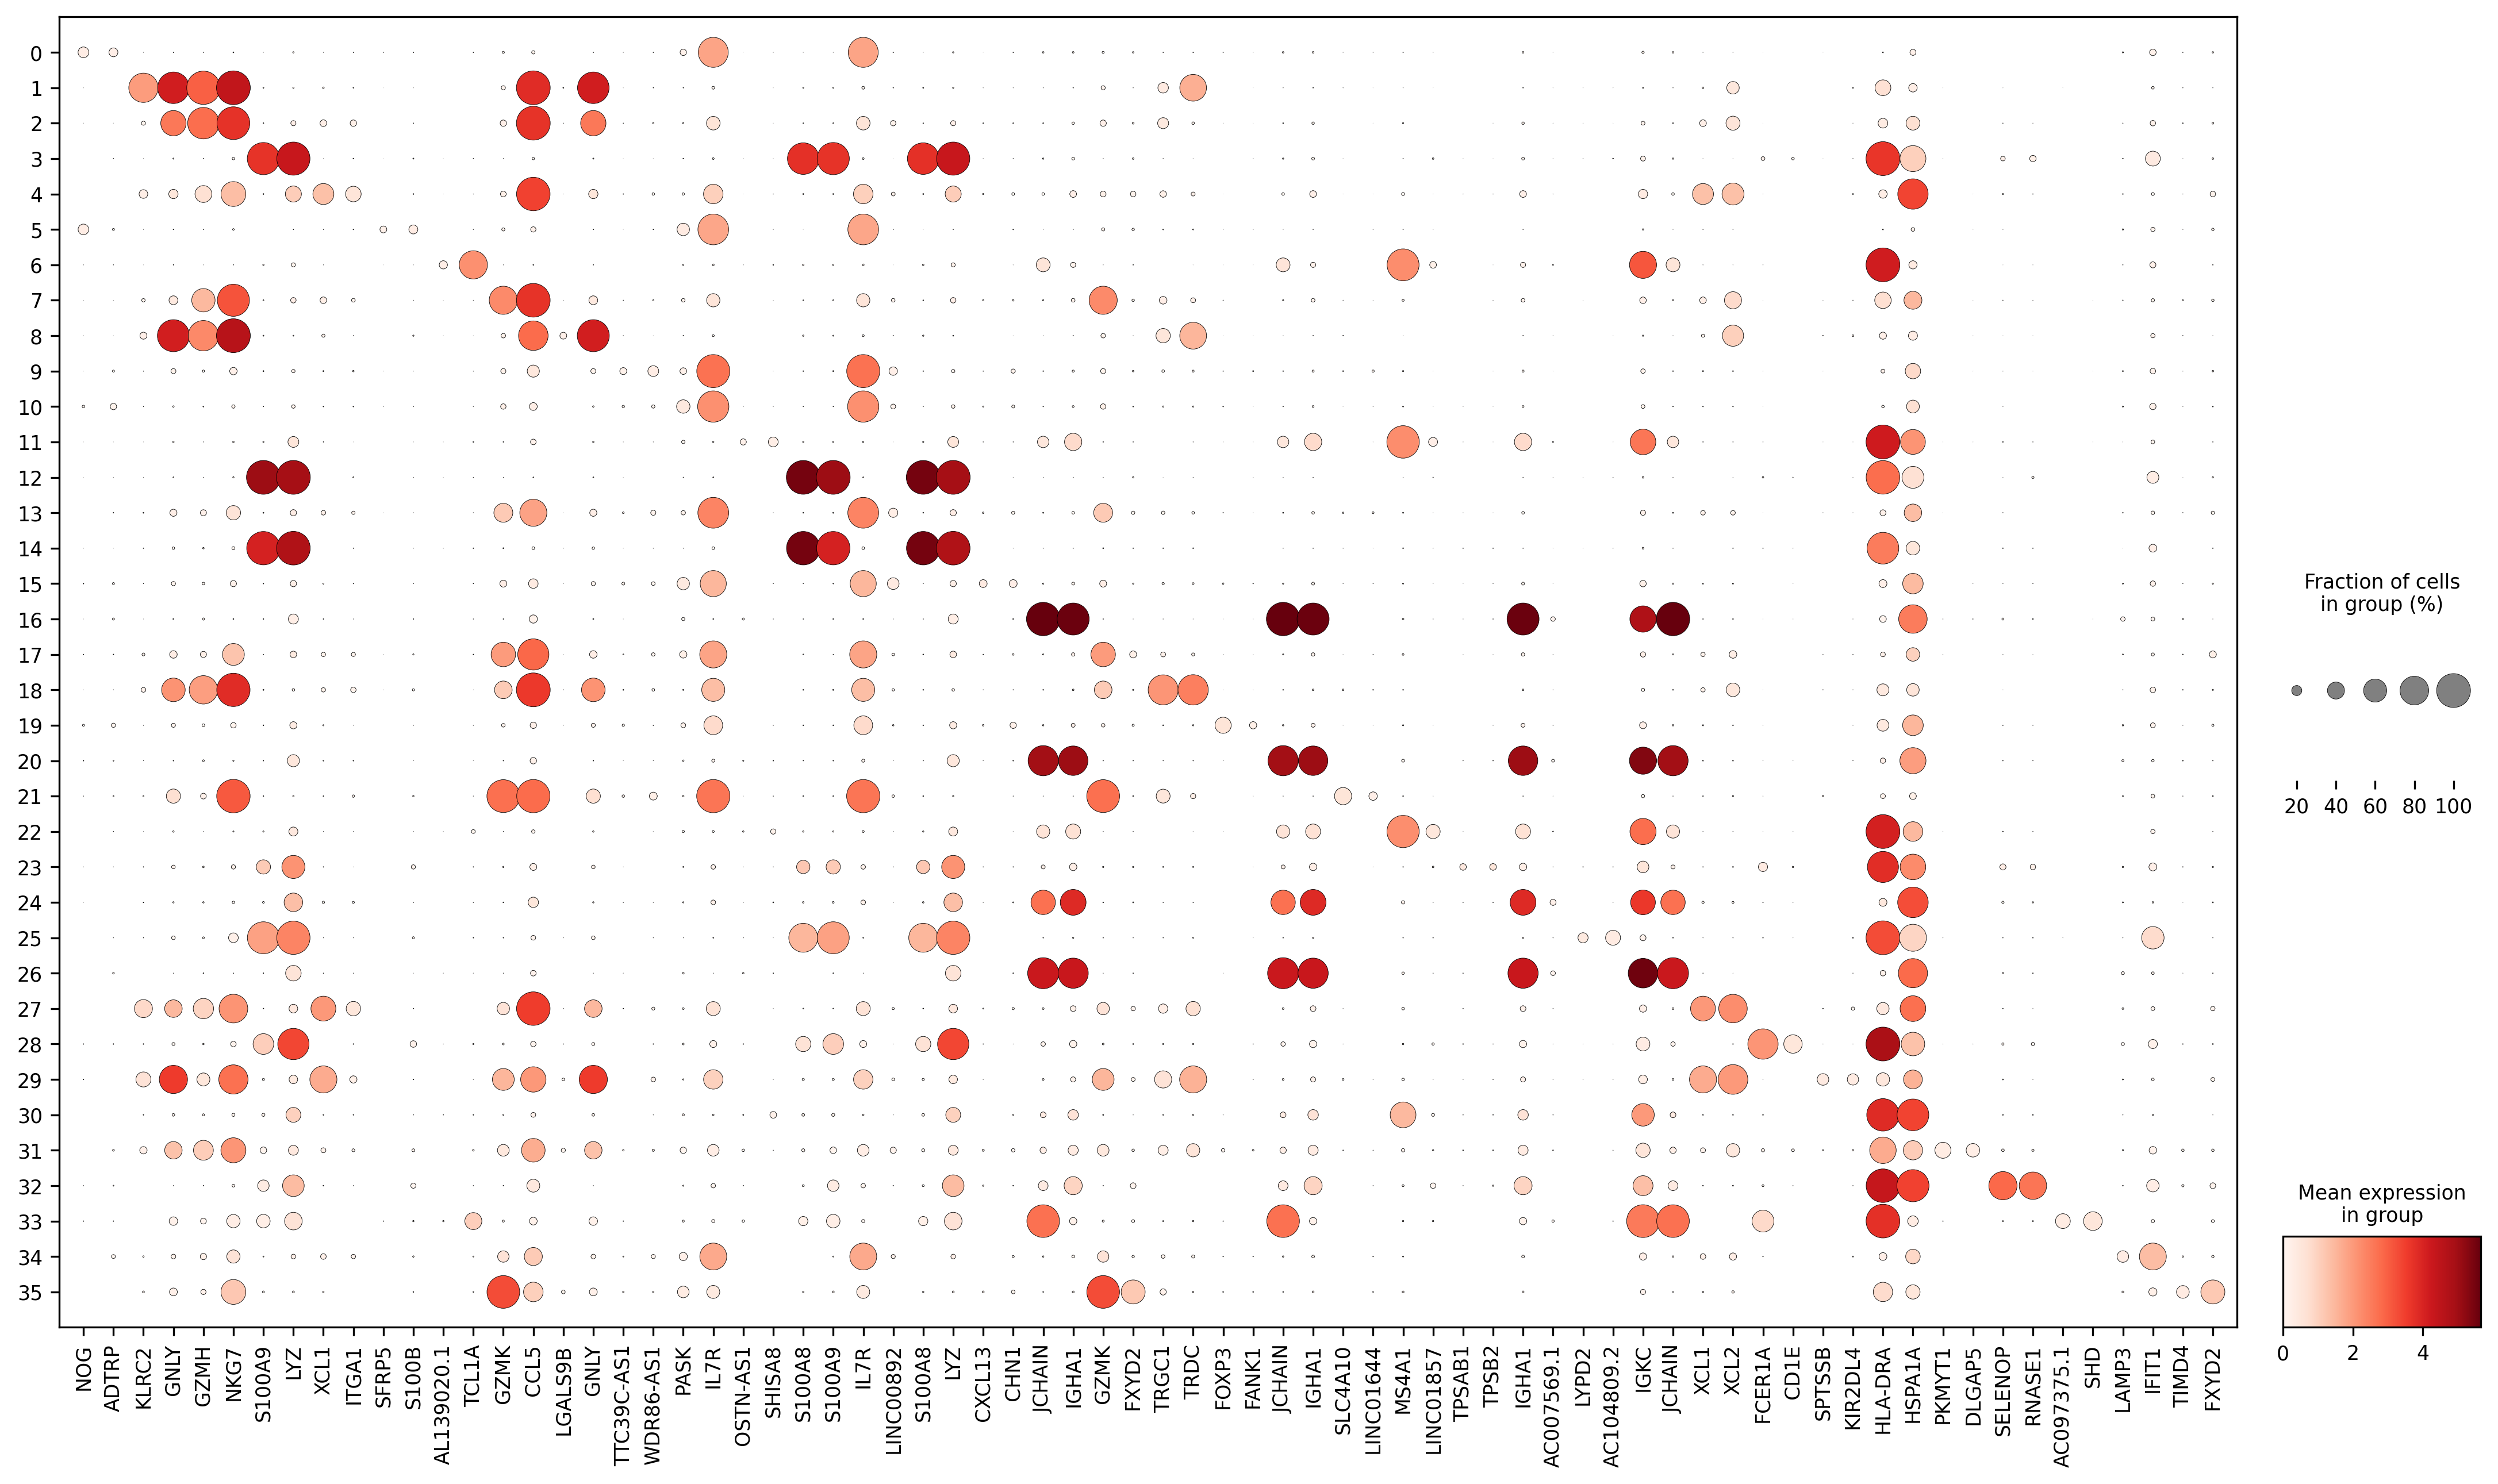

In [114]:
sc.pl.dotplot(cx_pbmc_immune,top2_markers['names'].values,groupby='seurat_clusters',use_raw=False,figsize=(18,10))

In [3]:
immune_celltype_mapper = {
    '0':'T_CD4_ADTRP',
    '1':'T_CD8_GZMH',
    '2':'T_CD8_KLRC2',
    '3':'Mono_PID1',
    '4':'T_CD8_ITGA1',
    '5':'T_CD8_NELL2',
    '6':'B_IGHD',
    '7':'T_CD8_CCL5',
    '8':'NK_SPON2',
    '9':'T_CD4_TNFSFR4',
    '10':'T_CD4_PASK',
    '11':'B_BANK1',
    '12':'Mono_S100A9',
    '13':'T_CD4_IL7R',
    '14':'Mono_S100A8',
    '15':'T_CD4_CXCL13',
    '16':'Plasma_IGHA1',
    '17':'T_CD8_GZMK',
    '18':'T_TRGC1_TRDC',
    '19':'T_CD4_FOXP3',
    '20':'Plasma_IGKV2D-28',
    '21':'MAIT',
    '22':'B_VPREB3',
    '23':'Mast',
    '24':'Plasma_HSPA1B',
    '25':'Mono_CDKN1C',
    '26':'Plasma_IGHG1',
    '27':'T_CD8_XCL1',
    '28':'cDC',
    '29':'T_CD8_KIR2DL4',
    '30':'B_CD83',
    '31':'T_MKI67',
    '32':'Mac_SELENOP',
    '33':'Mac_CLEC4A',
    '34':'T_CD4_LAMP3',
    '35':'T_CD4_IL10',
}

cx_pbmc_immune.obs['celltype_minor'] = [immune_celltype_mapper[str(c)] for c in cx_pbmc_immune.obs['seurat_clusters']]

In [4]:
cx_pbmc_immune.obs[['umap_1','umap_2']] = cx_pbmc_immune.obsm['X_umap']

In [6]:
cx_pbmc_immune

AnnData object with n_obs × n_vars = 79596 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'ident', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'sample', 'RNA_snn_res.2', 'seurat_clusters', 'celltype_submarkers', 'celltype_major', 'celltype_minor', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'tissue', 'RNA_snn_res.0.5', 'integrated_snn_res.2', 'integrated_snn_res.1.5', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.4', 'integrated_snn_res.2.5', 'integrated_snn_res.3', 'cli_state', 'umap_1', 'umap_2'
    var: 'features'
    obsm: 'X_umap'

In [8]:
cx_pbmc_immune.obs[['celltype_minor','tissue','cli_state','nCount_RNA','nFeature_RNA','percent.mt','sample','umap_1','umap_2']].to_csv('source_data/source_data_fig4a&b&sfig4a.csv')

In [17]:
pd.concat([cx_pbmc_immune.obs['celltype_minor'],cx_pbmc_immune.to_df().loc[:,['IGHD','TCL1A','VPREB3','CD27','BANK1','CD86','CD83']]],axis=1).to_csv('source_data/source_data_sfig5a.csv')

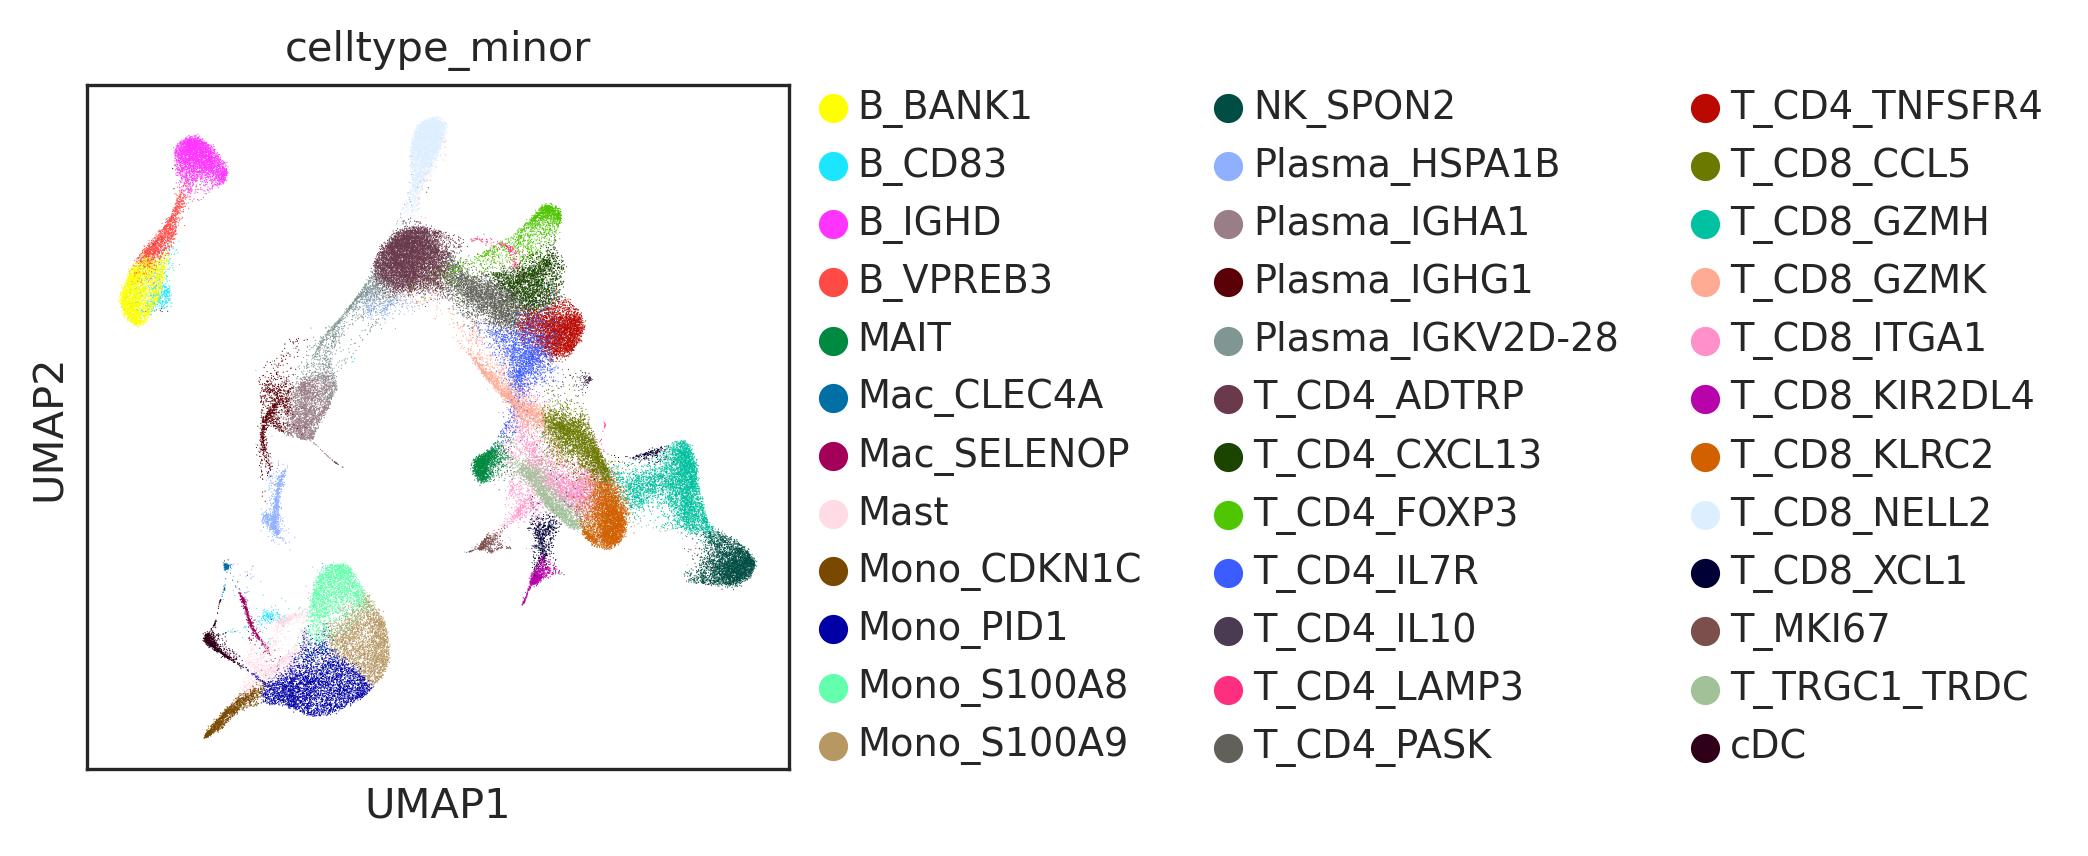

In [11]:
sc.pl.umap(cx_pbmc_immune,color=['celltype_minor'],alpha=1,size=0.3)#,save='_cx_pbmc_immune_celltype_minor.pdf'

... storing 'celltype_minor' as categorical


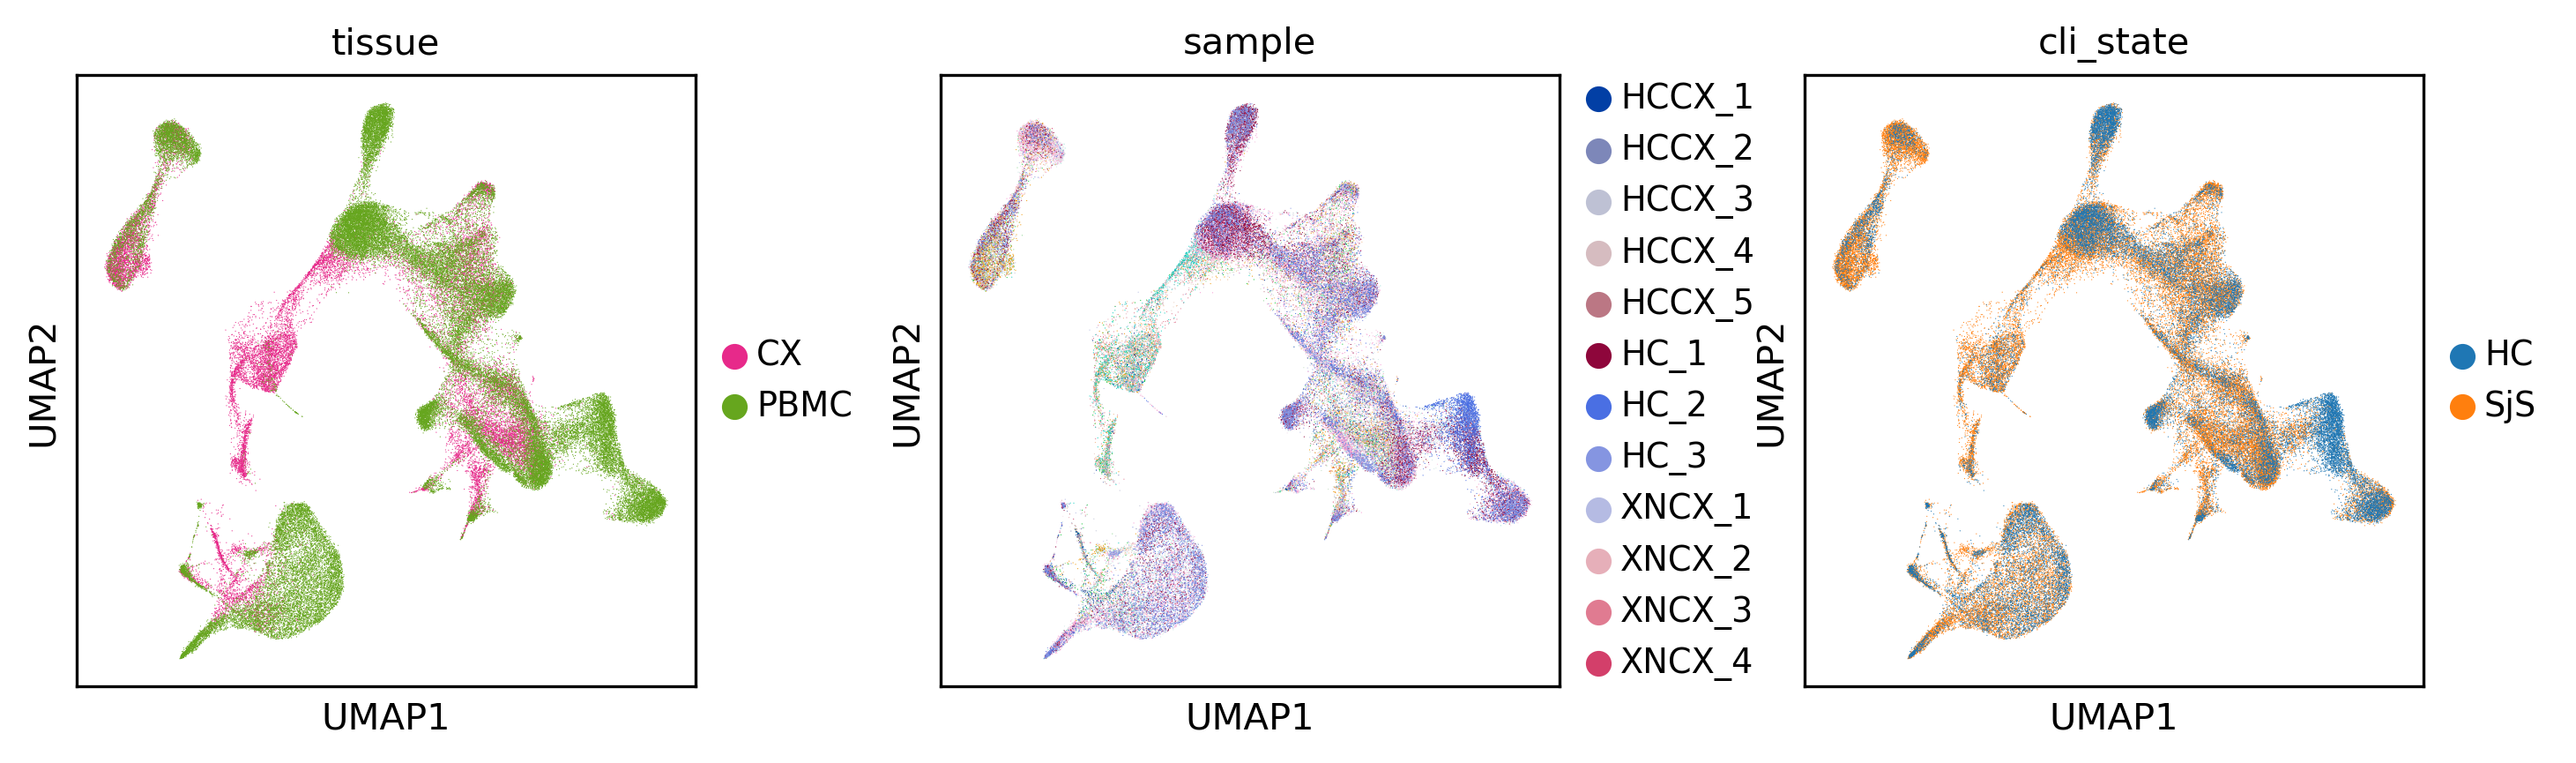

In [8]:
sc.pl.umap(cx_pbmc_immune,color=['tissue','sample','cli_state'],alpha=1,size=0.3)

In [3]:
sns.set_style('ticks')

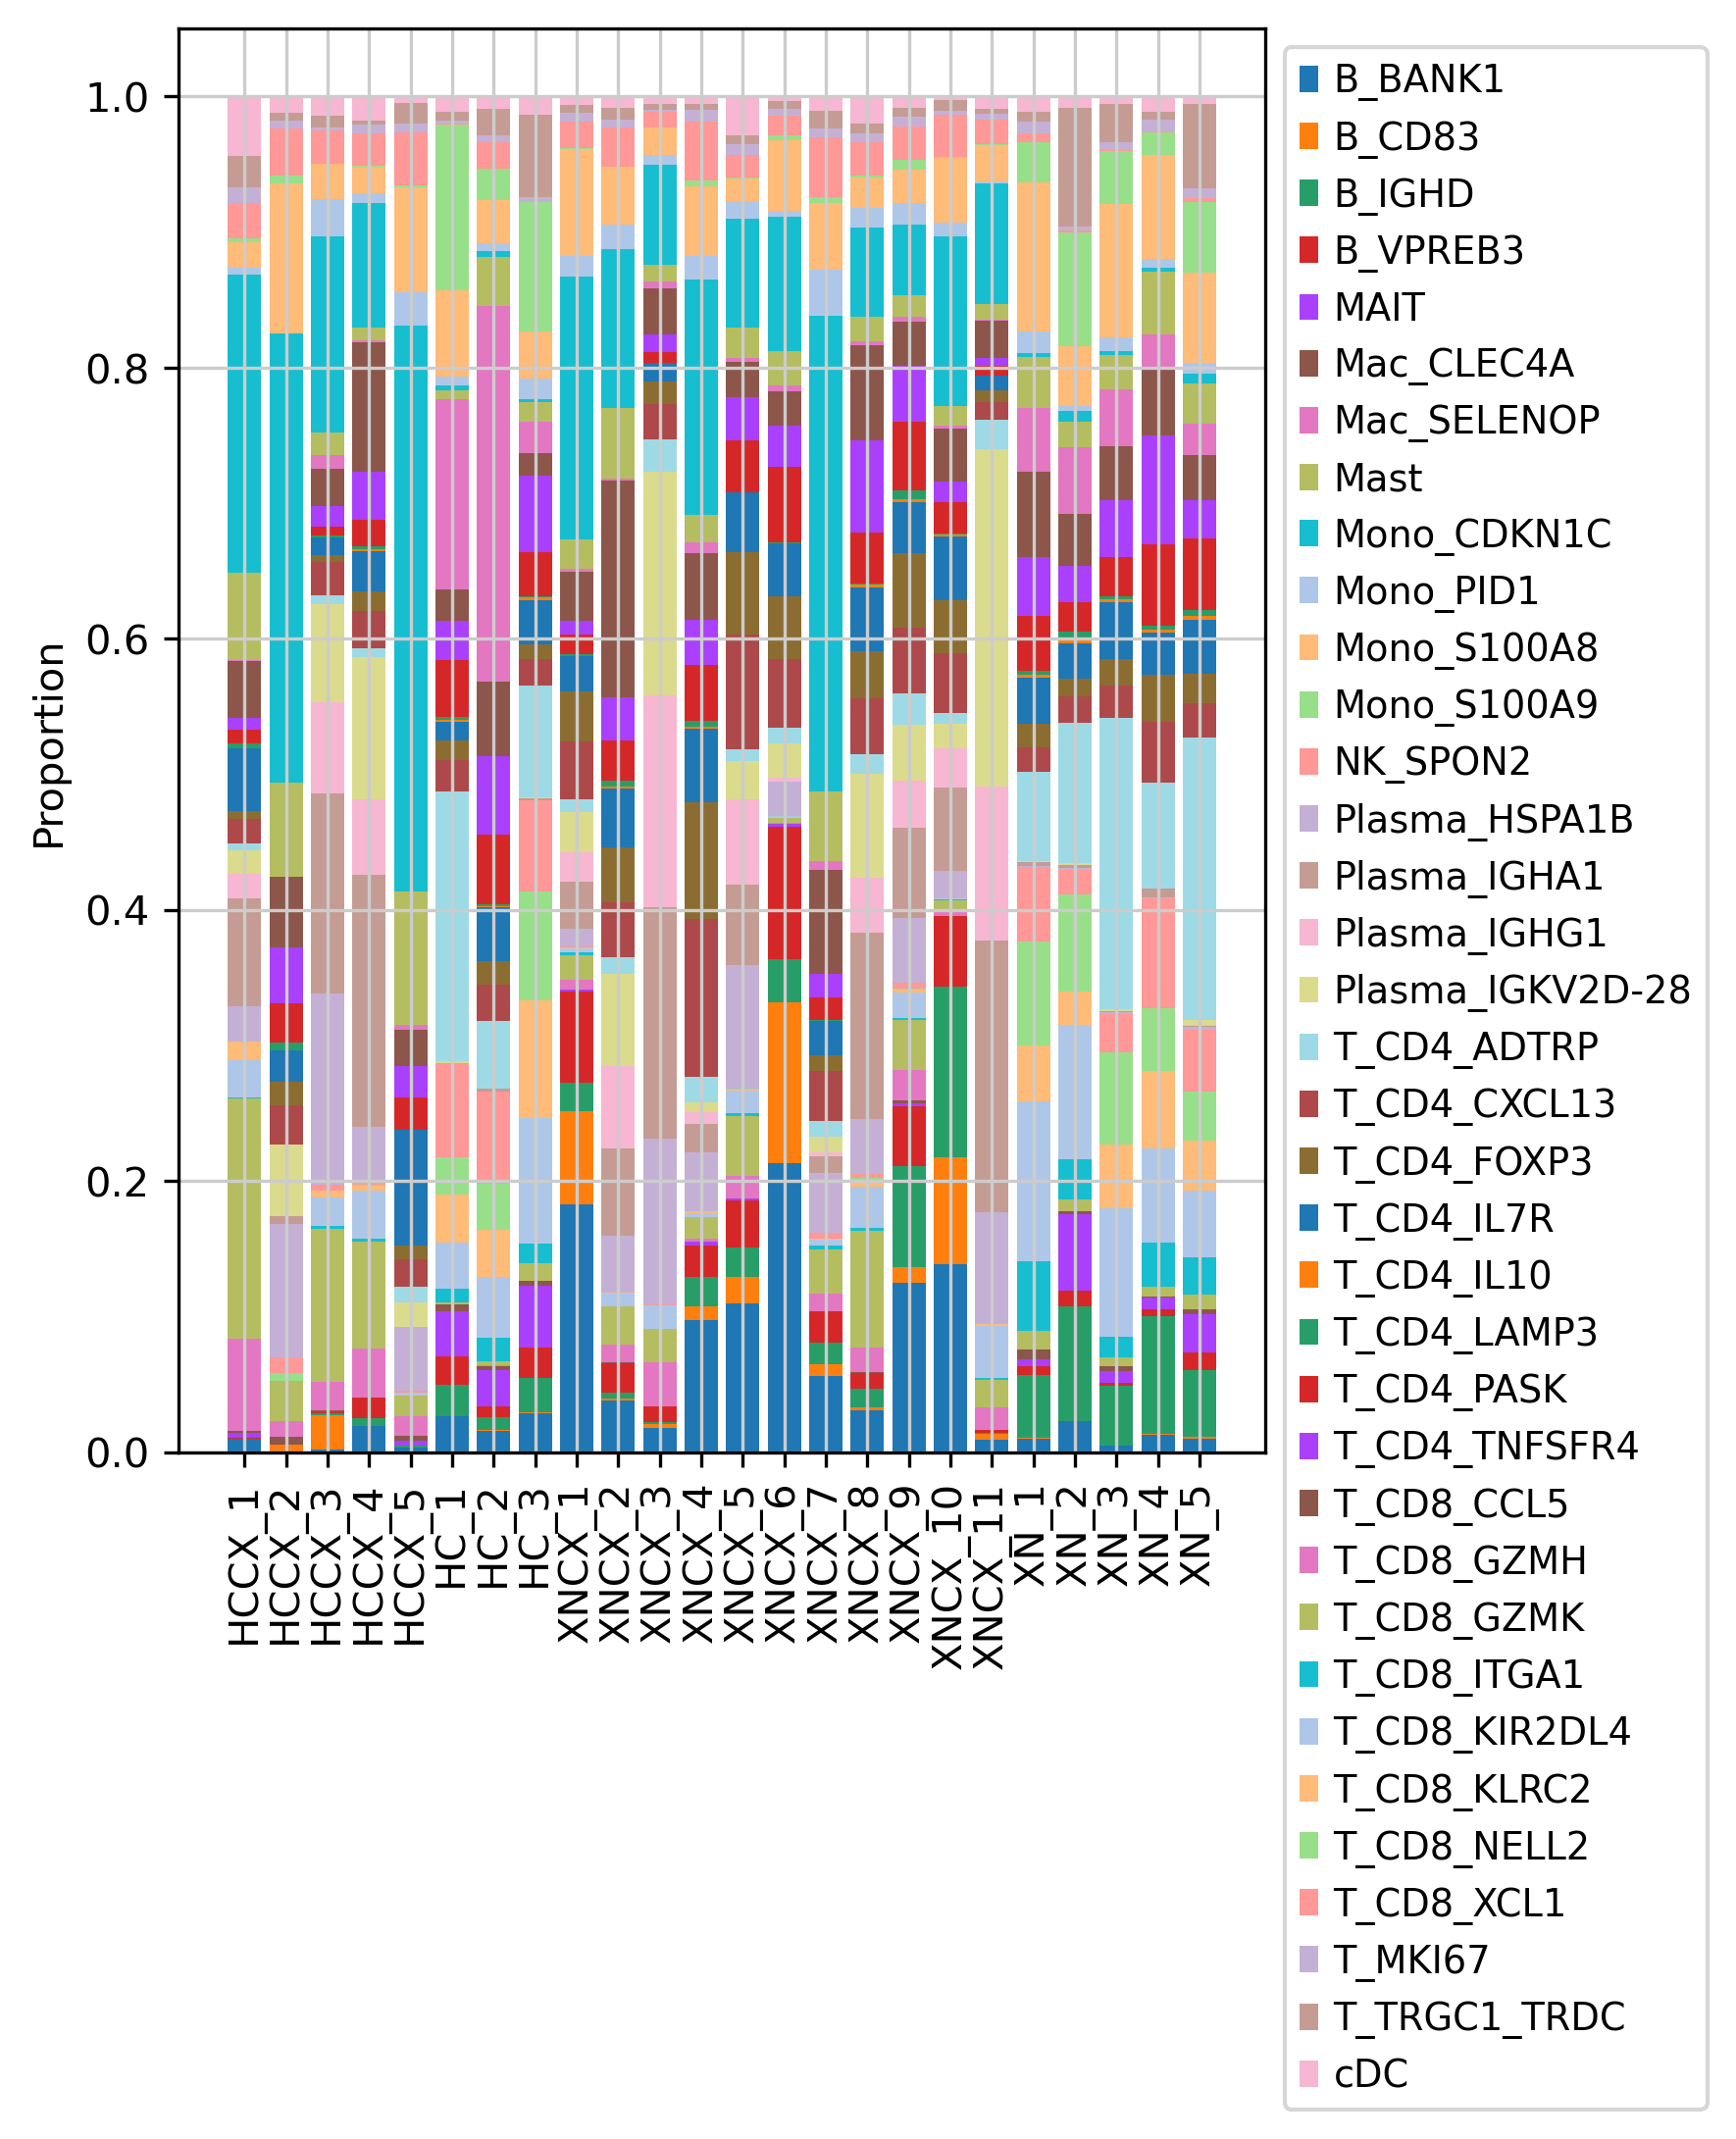

In [10]:
# minor_p_df = plot_proportion(cx_pbmc_immune.obs,obs_x='sample',obs_y='celltype_minor',obs_x_order=cx_pbmc_immune.obs['sample'].cat.categories,obs_y_order=cx_pbmc_immune.obs['celltype_minor'].cat.categories,colors=cx_pbmc_immune.uns['celltype_minor_colors'],figsize=(6,7),save='cx_pbmc_immune_results/ .pdf')
minor_p_df = plot_proportion(cx_pbmc_immune.obs,obs_x='sample',obs_y='celltype_minor',obs_x_order=cx_pbmc_immune.obs['sample'].cat.categories,obs_y_order=cx_pbmc_immune.obs['celltype_minor'].cat.categories,figsize=(6,7))
minor_p_df_count = pd.DataFrame()

count = 0
for i in minor_p_df.index:
    for c in minor_p_df.columns:
        minor_p_df_count.loc[count,['celltype_minor','sample','proportion']] = [i,c,minor_p_df.loc[i,c]]
        count += 1

minor_p_df_count.loc[minor_p_df_count['sample'].isin(['HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5','HC_1','HC_2','HC_3']),'cli_state'] = 'HC'
minor_p_df_count.loc[minor_p_df_count['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11','XN_1','XN_2','XN_3','XN_4','XN_5']),'cli_state'] = 'SjS'
minor_p_df_count.loc[minor_p_df_count['sample'].isin(['XN_1','XN_2','XN_3','XN_4','XN_5','HC_1','HC_2','HC_3']),'tissue'] = 'PBMC'
minor_p_df_count.loc[minor_p_df_count['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11','HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5']),'tissue'] = 'CX'


In [37]:
minor_p_df_count

celltype_minor  sample  proportion cli_state tissue
0          B_BANK1  HCCX_1    0.009960        HC     CX
1          B_BANK1  HCCX_2    0.000000        HC     CX
2          B_BANK1  HCCX_3    0.002195        HC     CX
3          B_BANK1  HCCX_4    0.019048        HC     CX
4          B_BANK1  HCCX_5    0.003350        HC     CX
..             ...     ...         ...       ...    ...
859            cDC    XN_1    0.011311       SjS   PBMC
860            cDC    XN_2    0.008290       SjS   PBMC
861            cDC    XN_3    0.005408       SjS   PBMC
862            cDC    XN_4    0.011119       SjS   PBMC
863            cDC    XN_5    0.005321       SjS   PBMC

[864 rows x 5 columns]

In [18]:
from scipy.stats import ttest_ind

In [26]:
print('SG')
for c in np.unique(minor_p_df_count.celltype_minor):
    print(c)
    print(ttest_ind(minor_p_df_count[(minor_p_df_count['tissue'] == 'CX')&(minor_p_df_count['celltype_minor']==c)&(minor_p_df_count['cli_state']=='SjS')]['proportion'],minor_p_df_count[(minor_p_df_count['tissue'] == 'CX')&(minor_p_df_count['celltype_minor']==c)&(minor_p_df_count['cli_state']=='HC')]['proportion']))
print('PBMC')
for c in np.unique(minor_p_df_count.celltype_minor):
    print(c)
    print(ttest_ind(minor_p_df_count[(minor_p_df_count['tissue'] == 'PBMC')&(minor_p_df_count['celltype_minor']==c)&(minor_p_df_count['cli_state']=='SjS')]['proportion'],minor_p_df_count[(minor_p_df_count['tissue'] == 'PBMC')&(minor_p_df_count['celltype_minor']==c)&(minor_p_df_count['cli_state']=='HC')]['proportion']))

SG
B_BANK1
Ttest_indResult(statistic=2.7461460283131838, pvalue=0.015763811476951377)
B_CD83
Ttest_indResult(statistic=1.2630987842089363, pvalue=0.22718516340355668)
B_IGHD
Ttest_indResult(statistic=1.6698160382920226, pvalue=0.11715335271054694)
B_VPREB3
Ttest_indResult(statistic=2.4257494146030725, pvalue=0.02938177779884175)
MAIT
Ttest_indResult(statistic=-0.25949610176470184, pvalue=0.7990294511898239)
Mac_CLEC4A
Ttest_indResult(statistic=-2.9941344463881543, pvalue=0.00966319802183743)
Mac_SELENOP
Ttest_indResult(statistic=-2.159394181093636, pvalue=0.04865760640510912)
Mast
Ttest_indResult(statistic=-2.490387465438439, pvalue=0.025943832374508296)
Mono_CDKN1C
Ttest_indResult(statistic=0.16470370706944518, pvalue=0.8715316262600757)
Mono_PID1
Ttest_indResult(statistic=-0.5167112355593371, pvalue=0.6134231352802846)
Mono_S100A8
Ttest_indResult(statistic=-2.023626351918149, pvalue=0.06253078334591412)
Mono_S100A9
Ttest_indResult(statistic=-1.3216350419493537, pvalue=0.2074807656428

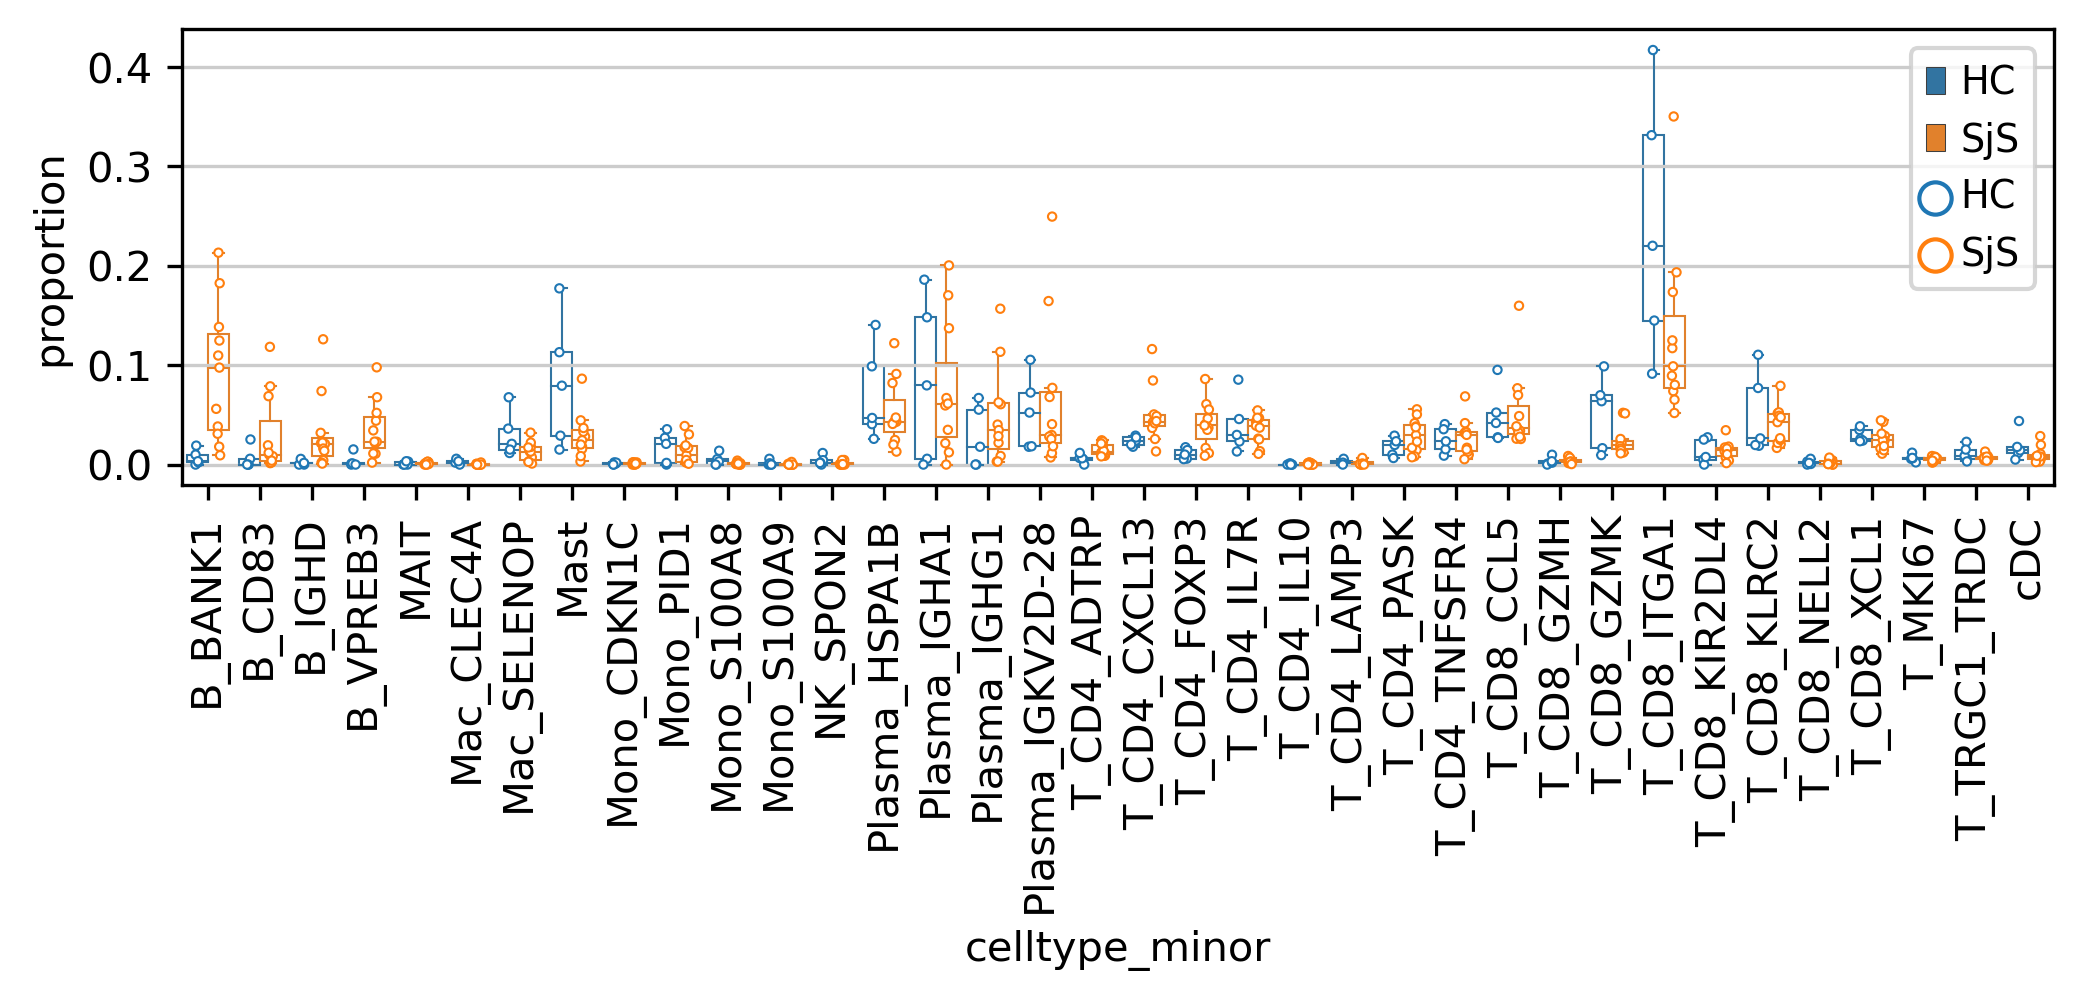

In [11]:
fig,ax=plt.subplots(figsize=(8,2))
sns.boxplot(data=minor_p_df_count[minor_p_df_count['tissue'] == 'CX'],y='proportion',x='celltype_minor',hue='cli_state',ax=ax,fliersize=0,linewidth=0.5)
sns.stripplot(data=minor_p_df_count[minor_p_df_count['tissue'] == 'CX'],y='proportion',x='celltype_minor',hue='cli_state',ax=ax,dodge=True,size=2,linewidth=0.5)
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

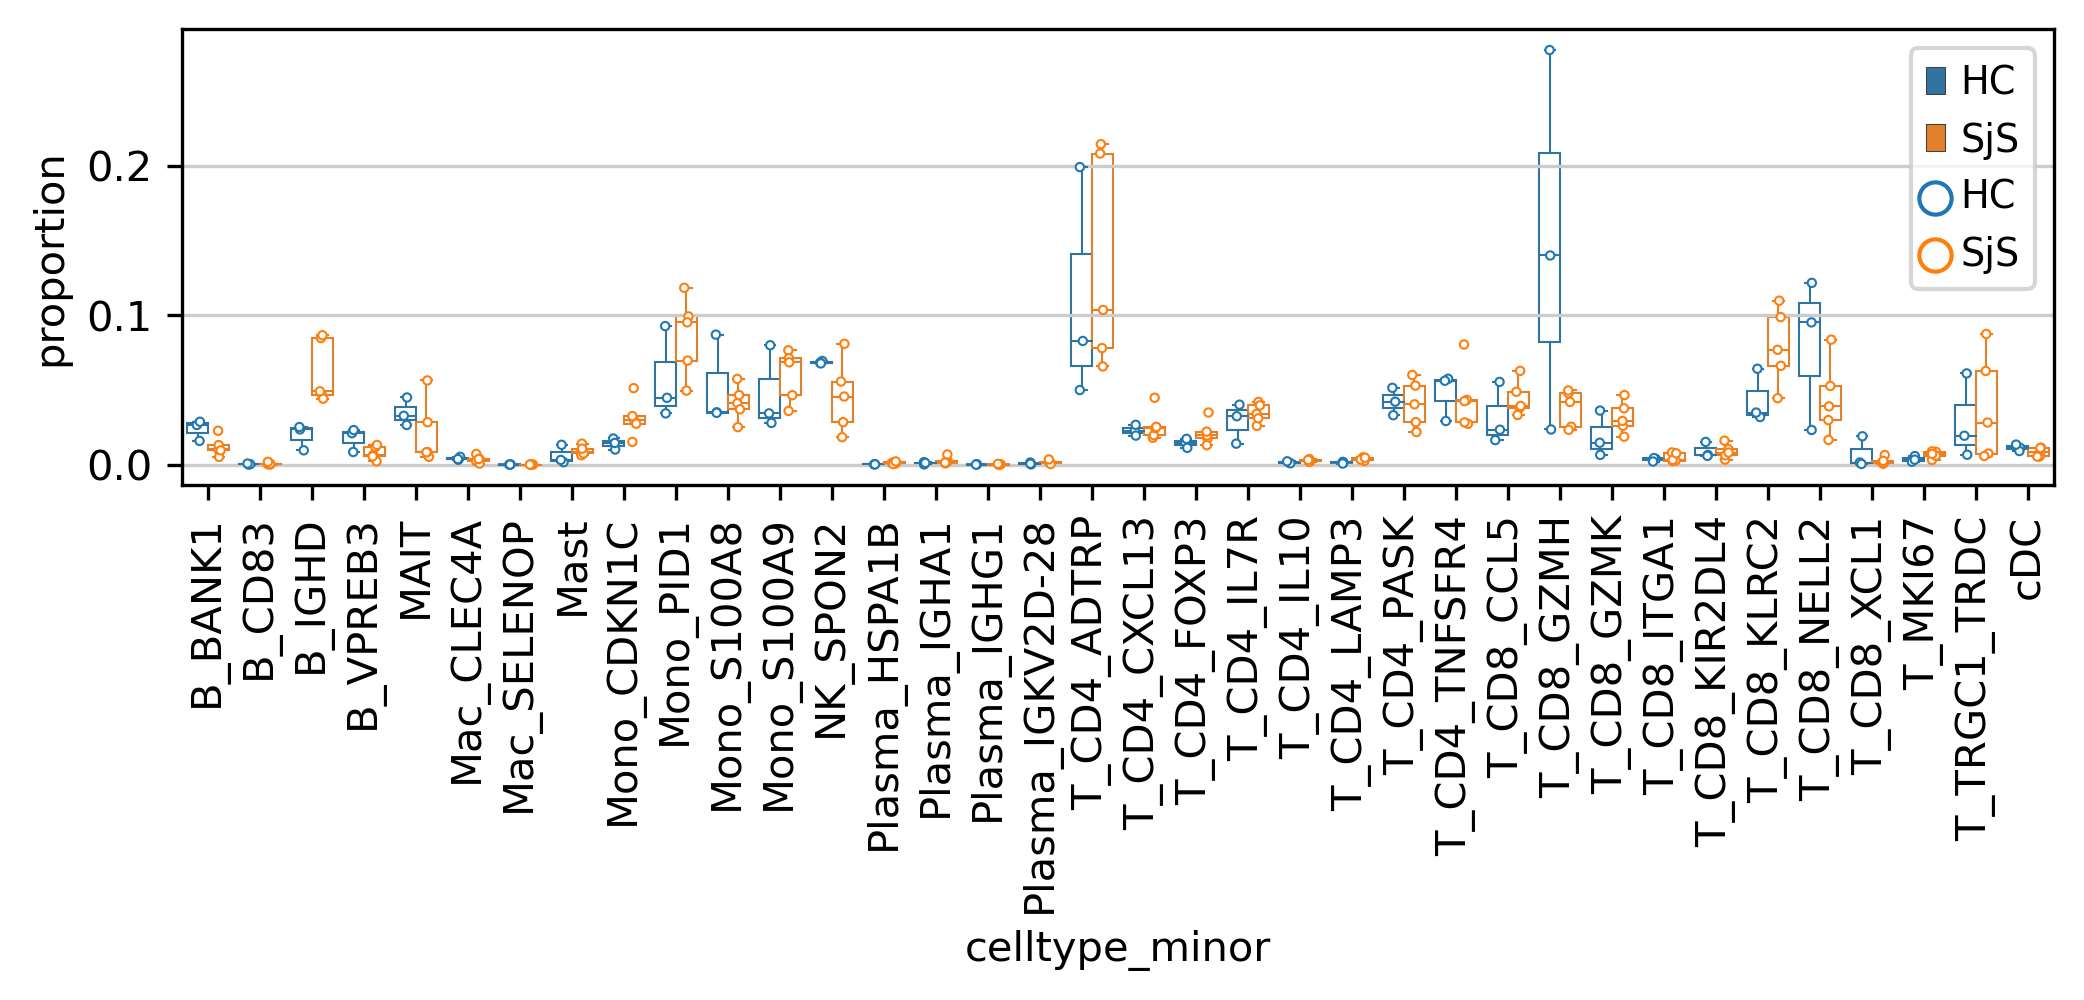

In [12]:
fig,ax=plt.subplots(figsize=(8,2))
sns.boxplot(data=minor_p_df_count[minor_p_df_count['tissue'] == 'PBMC'],y='proportion',x='celltype_minor',hue='cli_state',ax=ax,fliersize=0,linewidth=0.5)
sns.stripplot(data=minor_p_df_count[minor_p_df_count['tissue'] == 'PBMC'],y='proportion',x='celltype_minor',hue='cli_state',ax=ax,dodge=True,size=2,linewidth=0.5)
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

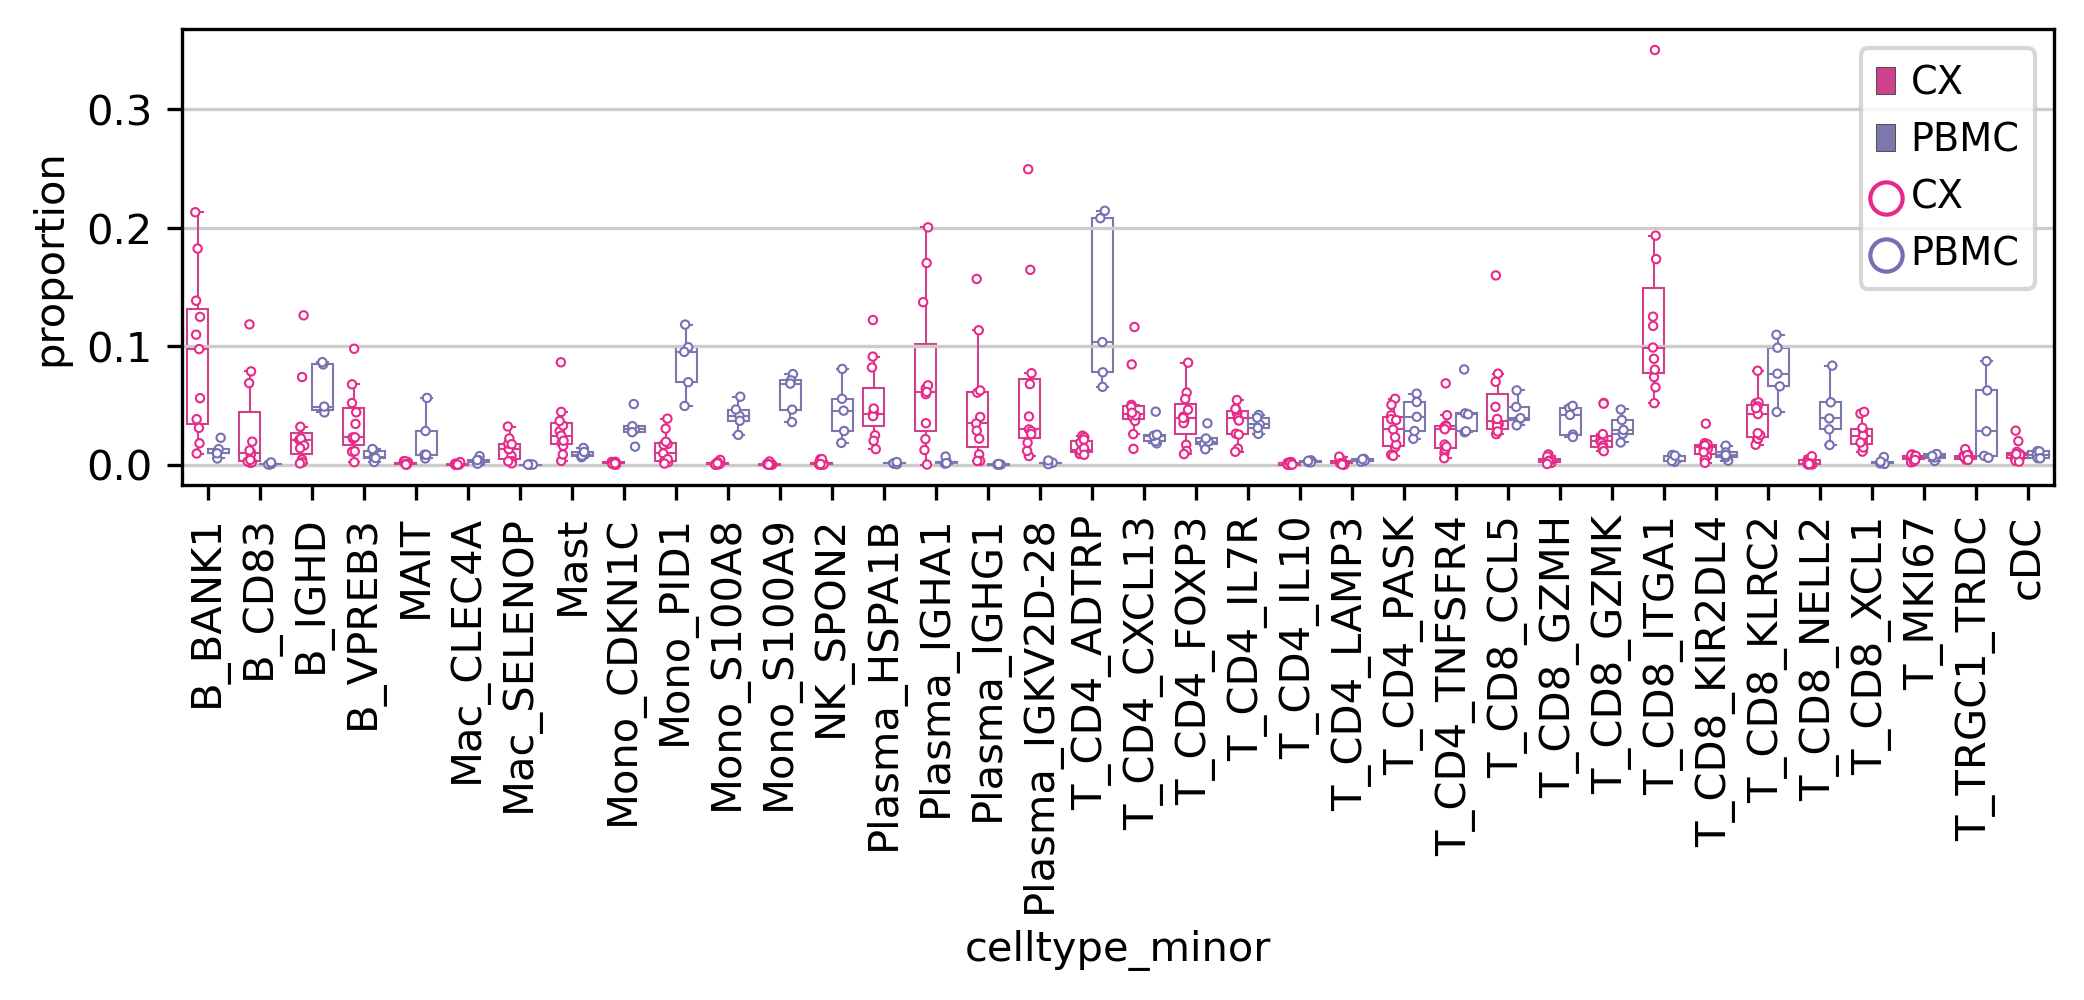

In [13]:
fig,ax=plt.subplots(figsize=(8,2))
sns.boxplot(data=minor_p_df_count[minor_p_df_count['cli_state'] == 'SjS'],y='proportion',x='celltype_minor',hue='tissue',ax=ax,fliersize=0,linewidth=0.5,palette=sns.color_palette('Dark2',n_colors=4)[2:][::-1])
sns.stripplot(data=minor_p_df_count[minor_p_df_count['cli_state'] == 'SjS'],y='proportion',x='celltype_minor',hue='tissue',ax=ax,dodge=True,size=2,linewidth=0.5,palette=sns.color_palette('Dark2',n_colors=4)[2:][::-1])
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

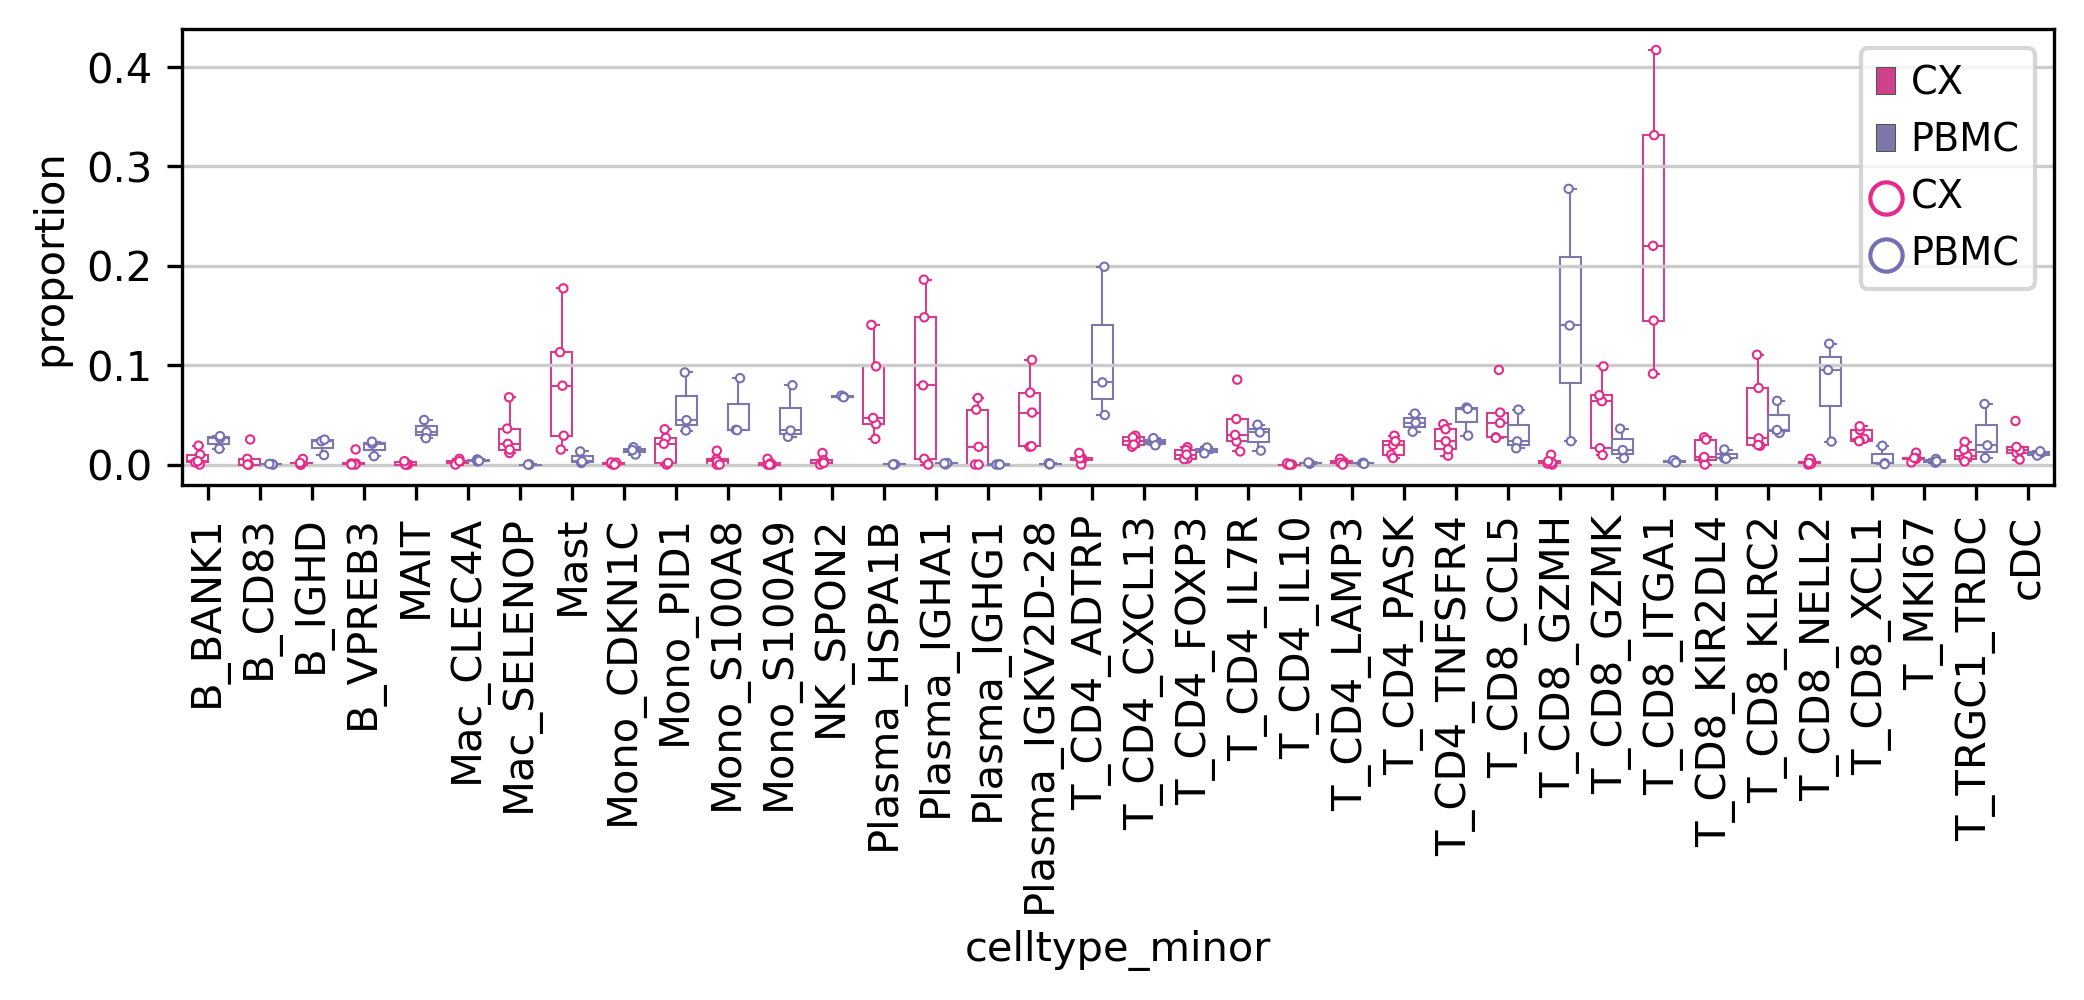

In [14]:
fig,ax=plt.subplots(figsize=(8,2))
sns.boxplot(data=minor_p_df_count[minor_p_df_count['cli_state'] == 'HC'],y='proportion',x='celltype_minor',hue='tissue',ax=ax,fliersize=0,linewidth=0.5,palette=sns.color_palette('Dark2',n_colors=4)[2:][::-1])
sns.stripplot(data=minor_p_df_count[minor_p_df_count['cli_state'] == 'HC'],y='proportion',x='celltype_minor',hue='tissue',ax=ax,dodge=True,size=2,linewidth=0.5,palette=sns.color_palette('Dark2',n_colors=4)[2:][::-1])
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

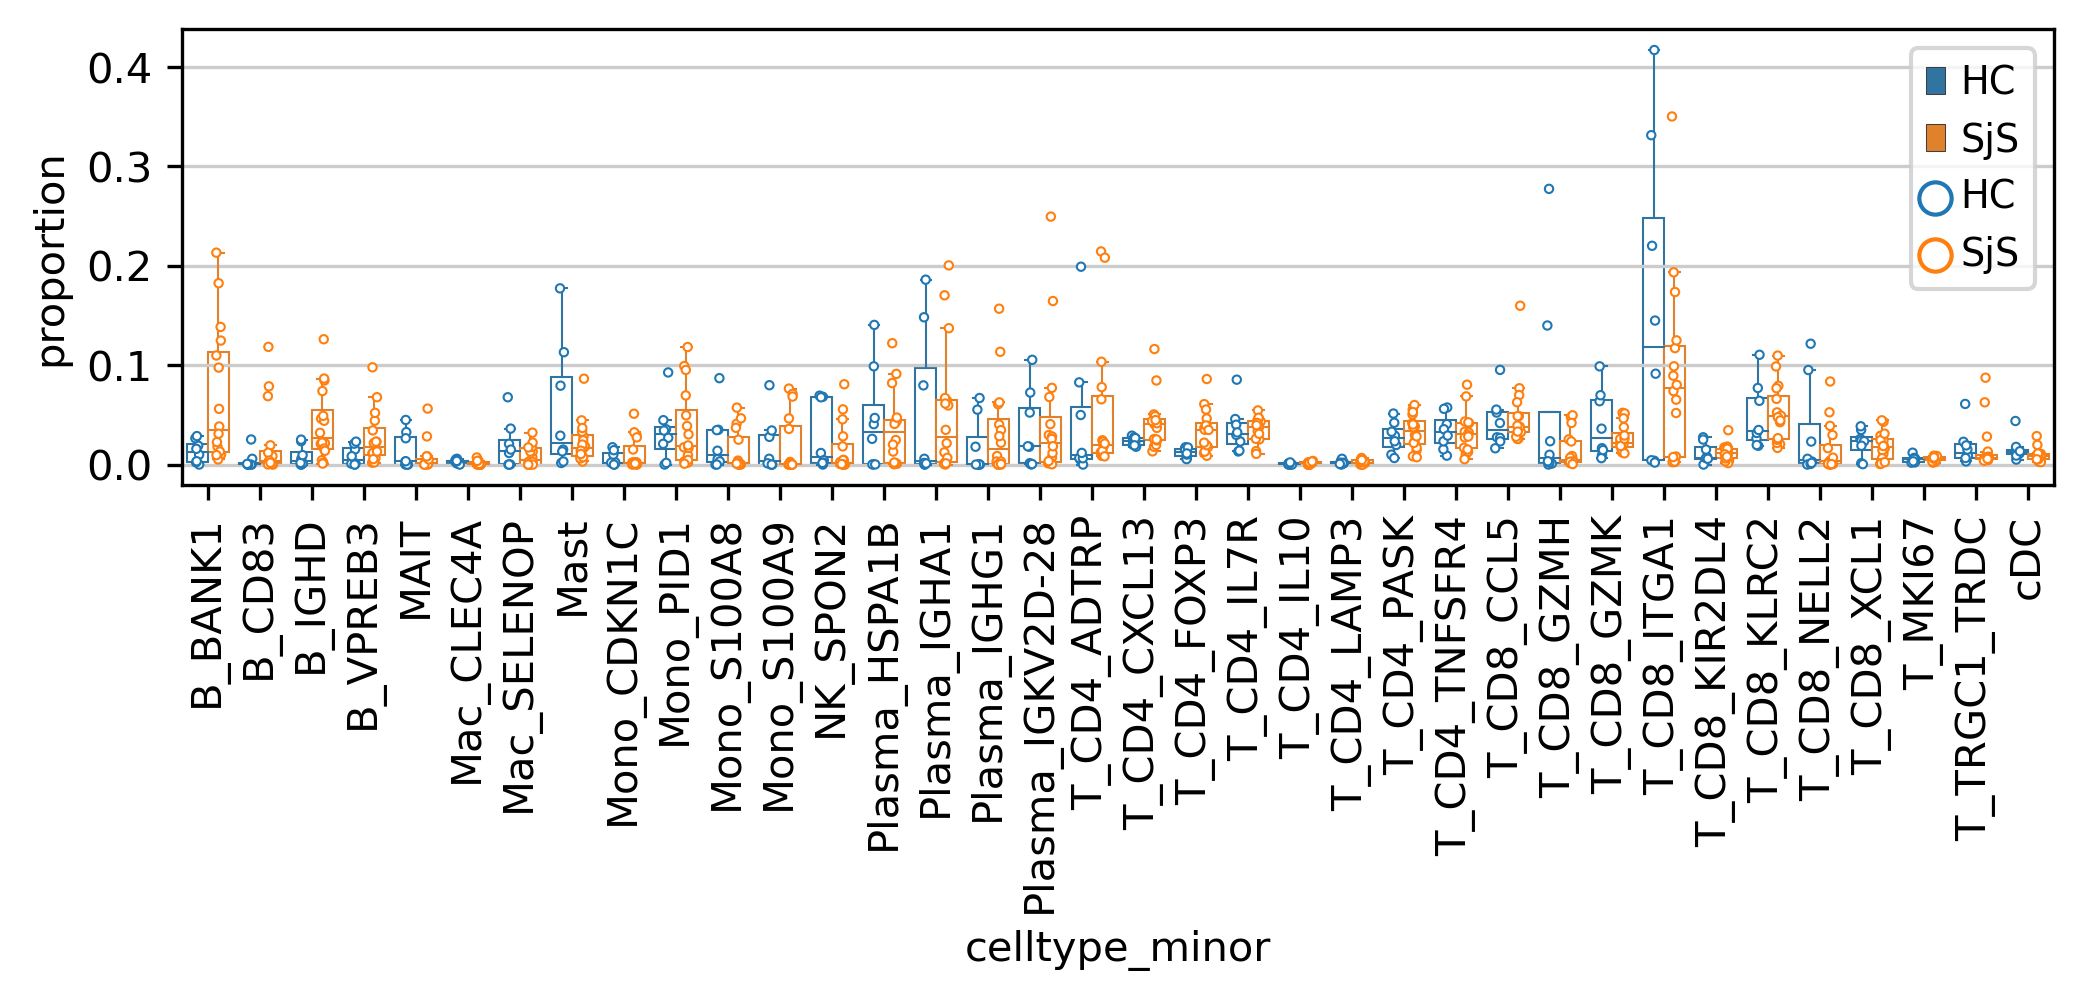

In [15]:
fig,ax=plt.subplots(figsize=(8,2))
sns.boxplot(data=minor_p_df_count,y='proportion',x='celltype_minor',hue='cli_state',ax=ax,fliersize=0,linewidth=0.5)
sns.stripplot(data=minor_p_df_count,y='proportion',x='celltype_minor',hue='cli_state',ax=ax,dodge=True,size=2,linewidth=0.5)
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [16]:
cx_pbmc_immune.obs['tissue_cli'] = [cx_pbmc_immune.obs['tissue'][i]+'_'+cx_pbmc_immune.obs['cli_state'][i] for i in range(len(cx_pbmc_immune.obs))]
cx_pbmc_immune.obs['tissue_cli'] = pd.Categorical(cx_pbmc_immune.obs['tissue_cli'])

In [ ]:
# cx_pbmc_immune.raw.var.index = cx_pbmc_immune.raw.var['_index'].values
# cx_pbmc_immune.raw.var.columns = ['features']

In [141]:
cx_pbmc_immune.write_h5ad('s16_cx_pbmc_immune_inte_seurat_rpca_pc20_neighbor50.h5ad')

In [129]:
cx_pbmc_immune.raw.to_adata().write_h5ad('s16_cx_pbmc_immune_inte_seurat_rpca_pc20_neighbor50_raw.h5ad')

In [46]:
cli_state_minor_p_df['fc'] = np.log2(cli_state_minor_p_df['SjS']/cli_state_minor_p_df['HC'])
cli_state_minor_p_df['sum'] = cli_state_minor_p_df['SjS']+cli_state_minor_p_df['HC']
tissue_minor_p_df['fc'] = np.log2(tissue_minor_p_df['CX']/tissue_minor_p_df['PBMC'])
tissue_minor_p_df['sum'] = tissue_minor_p_df['CX']+tissue_minor_p_df['PBMC']

In [29]:
cx_pbmc_immune = sc.read_h5ad('s16_cx_pbmc_immune_inte_seurat_rpca_pc20_neighbor50.h5ad')

In [6]:
cx_pbmc_immune.obs.to_csv('s16_cx_pbmc_immune_inte_seurat_rpca_pc20_neighbor50_meta.csv')

In [30]:
cx_pbmc_immune

AnnData object with n_obs × n_vars = 79596 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'ident', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'sample', 'RNA_snn_res.2', 'seurat_clusters', 'celltype_submarkers', 'celltype_major', 'celltype_minor', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'tissue', 'RNA_snn_res.0.5', 'integrated_snn_res.2', 'integrated_snn_res.1.5', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.4', 'integrated_snn_res.2.5', 'integrated_snn_res.3', 'cli_state', 'tissue_cli'
    var: 'features'
    uns: 'celltype_minor_colors', 'cli_state_colors', 'rank_genes_groups', 'sample_colors', 'seurat_clusters_colors', 'tissue_colors'
    obsm: 'X_umap'

In [64]:
cx_pbmc_immune.obs

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
GGAGAACCAACGGCTC-1_1_1         CX     29874.0          2213    0.669478   
GCCATGGTCCCATTCG-1_1_1         CX     26995.0          2692    3.126505   
ACCCTTGCAACTTGCA-1_1_1         CX     25616.0          1805    0.698782   
TTCCGGTCAGTACTAC-1_1_1         CX     25288.0          2145    2.064220   
TTCGATTCAAGTGGTG-1_1_1         CX     25111.0          2023    0.485843   
...                           ...         ...           ...         ...   
ATACCTTGTTCTGACA-1_8_2       HC_3      1553.0           830    5.666452   
TTTGGAGTCGCATTAG-1_8_2       HC_3      1495.0           904    8.494983   
GAACACTCAACCGATT-1_8_2       HC_3      1426.0           808    9.677419   
CTGGCAGCAGTCCCGA-1_8_2       HC_3      1449.0           817   13.802622   
ATTCACTGTAATGATG-1_8_2       HC_3      1187.0           806    5.475990   

                         ident scDblFinder.sample scDblFinder.class  \
GGAGAACCAACGGCTC-1_1_1  XNCX_1             XNCX_1           singlet   
GCCATGGTCCCATTCG-1_1_1  XNCX_1             XNCX_1           singlet   
ACCCTTGCAACTTGCA-1_1_1  XNCX_1             XNCX_1           singlet   
TTCCGGTCAGTACTAC-1_1_1  XNCX_1             XNCX_1           singlet   
TTCGATTCAAGTGGTG-1_1_1  XNCX_1             XNCX_1           singlet   
...                        ...                ...               ...   
ATACCTTGTTCTGACA-1_8_2    HC_3               HC_3           singlet   
TTTGGAGTCGCATTAG-1_8_2    HC_3               HC_3           singlet   
GAACACTCAACCGATT-1_8_2    HC_3               HC_3           singlet   
CTGGCAGCAGTCCCGA-1_8_2    HC_3               HC_3           singlet   
ATTCACTGTAATGATG-1_8_2    HC_3               HC_3           singlet   

                        scDblFinder.score  scDblFinder.weighted  \
GGAGAACCAACGGCTC-1_1_1           0.077716              0.241938   
GCCATGGTCCCATTCG-1_1_1           0.100488              0.268660   
ACCCTTGCAACTTGCA-1_1_1           0.003645              0.188472   
TTCCGGTCAGTACTAC-1_1_1           0.003885              0.154595   
TTCGATTCAAGTGGTG-1_1_1           0.009338              0.046406   
...                                   ...                   ...   
ATACCTTGTTCTGACA-1_8_2           0.001300              0.125513   
TTTGGAGTCGCATTAG-1_8_2           0.000046              0.041745   
GAACACTCAACCGATT-1_8_2           0.004670              0.116749   
CTGGCAGCAGTCCCGA-1_8_2           0.003672              0.112462   
ATTCACTGTAATGATG-1_8_2           0.000600              0.100807   

                        scDblFinder.cxds_score  ... RNA_snn_res.0.5  \
GGAGAACCAACGGCTC-1_1_1            4.765032e-06  ...              NA   
GCCATGGTCCCATTCG-1_1_1            3.043927e-01  ...              NA   
ACCCTTGCAACTTGCA-1_1_1            1.868295e-62  ...              NA   
TTCCGGTCAGTACTAC-1_1_1            2.740662e-56  ...              NA   
TTCGATTCAAGTGGTG-1_1_1            2.640603e-01  ...              NA   
...                                        ...  ...             ...   
ATACCTTGTTCTGACA-1_8_2            3.335477e-02  ...               3   
TTTGGAGTCGCATTAG-1_8_2            1.943409e-02  ...               1   
GAACACTCAACCGATT-1_8_2            3.693030e-02  ...               7   
CTGGCAGCAGTCCCGA-1_8_2            2.923865e-02  ...               8   
ATTCACTGTAATGATG-1_8_2            2.303311e-02  ...               7   

                       integrated_snn_res.2 integrated_snn_res.1.5  \
GGAGAACCAACGGCTC-1_1_1                   20                     21   
GCCATGGTCCCATTCG-1_1_1                   16                     14   
ACCCTTGCAACTTGCA-1_1_1                    0                      0   
TTCCGGTCAGTACTAC-1_1_1                   16                     14   
TTCGATTCAAGTGGTG-1_1_1                   16                     14   
...                                     ...                    ...   
ATACCTTGTTCTGACA-1_8_2                   10                      1   
TTTGGAGTCGCATTAG-1_8_2                   14        

In [61]:
cx_all = sc.read_h5ad('s02_cx_annotated.h5ad')

In [68]:
cx_noimmune = cx_all[~cx_all.obs['celltype_major'].isin(['B', 'CD4_T', 'CD8_T', 'Mac/mo', 'Mast', 'Plasma'])]

In [80]:
cx_pbmc_all = sc.concat([cx_noimmune,cx_pbmc_immune])

In [81]:
cx_pbmc_all.obs = cx_pbmc_all.obs.drop(columns='RNA_snn_res.2')

In [82]:
cx_pbmc_all.write_h5ad('cx_pbmc_all.h5ad')

... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical


In [83]:
cx_pbmc_all_raw = cx_pbmc_all.raw.to_adata()

In [84]:
cx_pbmc_all_raw.write_h5ad('cx_pbmc_all_raw.h5ad')

In [86]:
cx_pbmc_all_raw.obs['state_celltype_minor'] = [cx_pbmc_all_raw.obs.iloc[i,-1]+'_'+cx_pbmc_all_raw.obs.iloc[i,-2] for i in range(len(cx_pbmc_all_raw.obs))]

In [88]:
state_celltype_minor_meta = cx_pbmc_all_raw.obs.loc[:,['state_celltype_minor']].reset_index()

In [90]:
state_celltype_minor_meta.columns = ['Cell','cell_type']
state_celltype_minor_meta.to_csv('cpdb_results/cx_pbmc_all_state_celltype_minor_meta.txt',sep='\t',index=False)

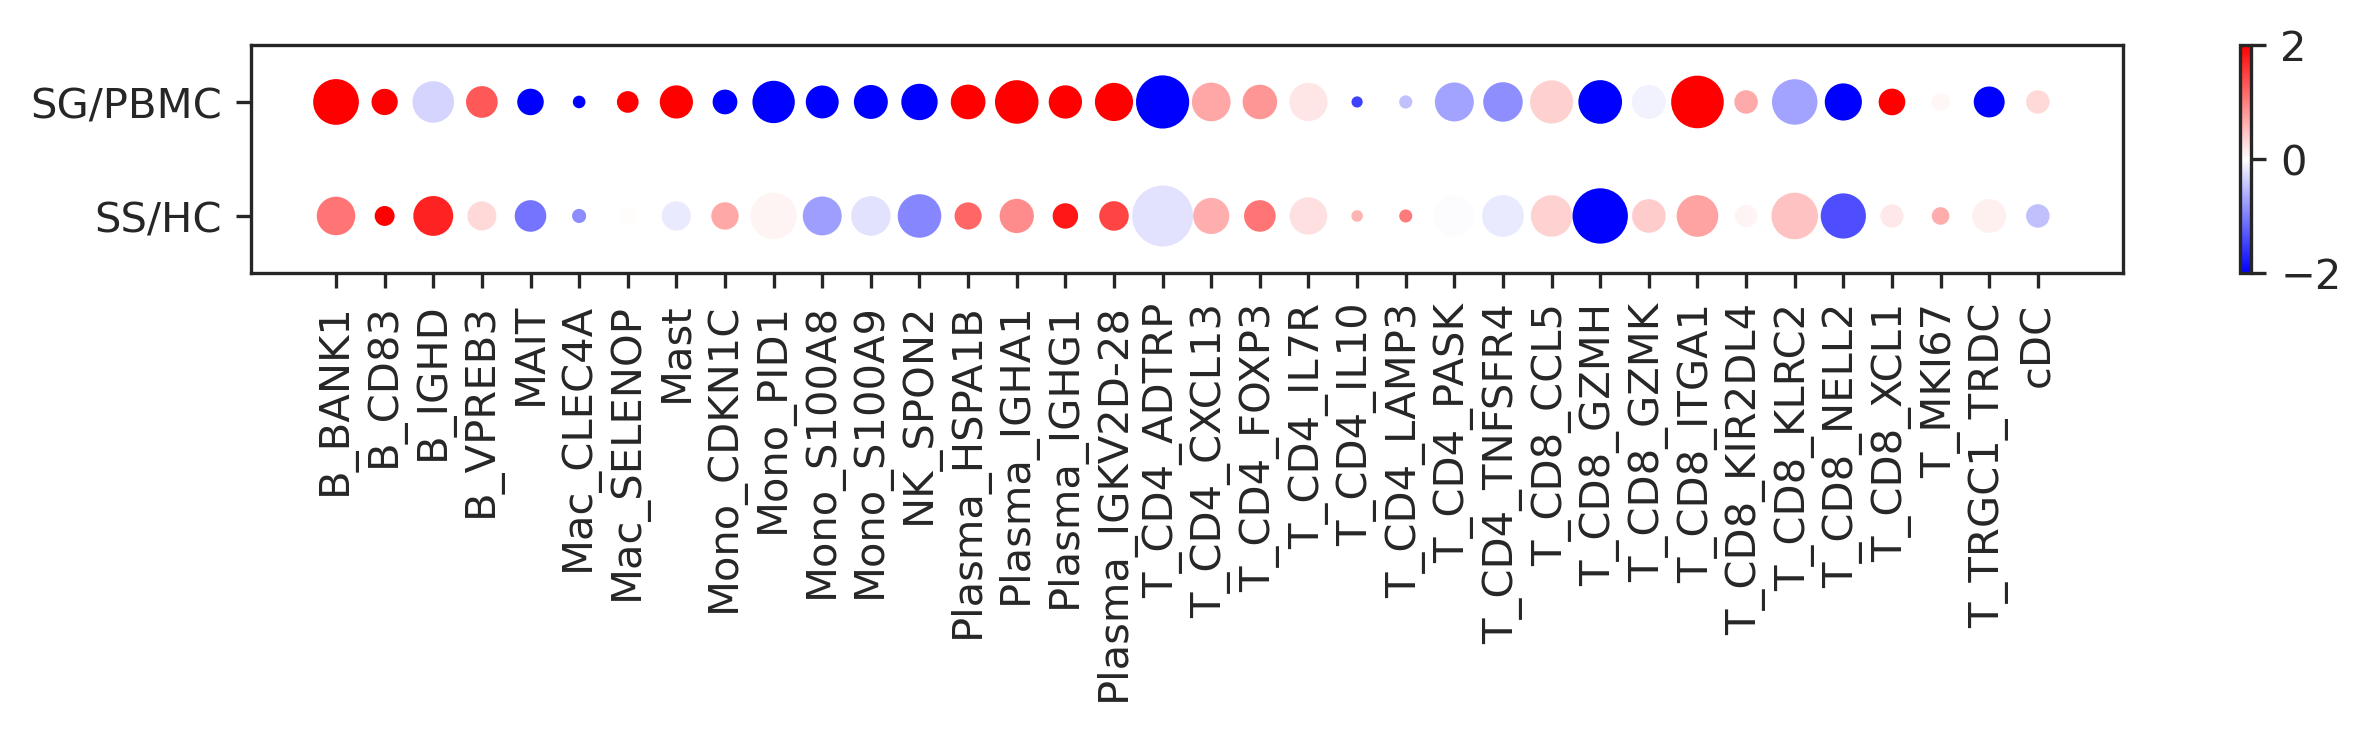

In [225]:
plt.subplots(figsize=(10,1))
plt.scatter(
    x=[list(range(len(cli_state_minor_p_df.index)))]*2,
    y=np.repeat(np.arange(2),len((cli_state_minor_p_df.index))),
    s=np.array(list(cli_state_minor_p_df['sum']) + list(tissue_minor_p_df['sum']))*1000,
    c=list(cli_state_minor_p_df['fc']) + list(tissue_minor_p_df['fc']),
    cmap='bwr',
    vmax=2,
    vmin=-2
)
plt.yticks([0,1],['SS/HC','SG/PBMC'])
plt.xticks(range(len(cli_state_minor_p_df.index)),cli_state_minor_p_df.index,rotation=90)
plt.colorbar()
plt.ylim(-0.5,1.5)
plt.savefig('cx_pbmc_immune_results/dotplot_cx_pbmc_immune_celltype_minor_clistate_tissue_proportion.pdf')
plt.show()

/home/qukun/xuhao/workspace/Utils/sc_plot.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


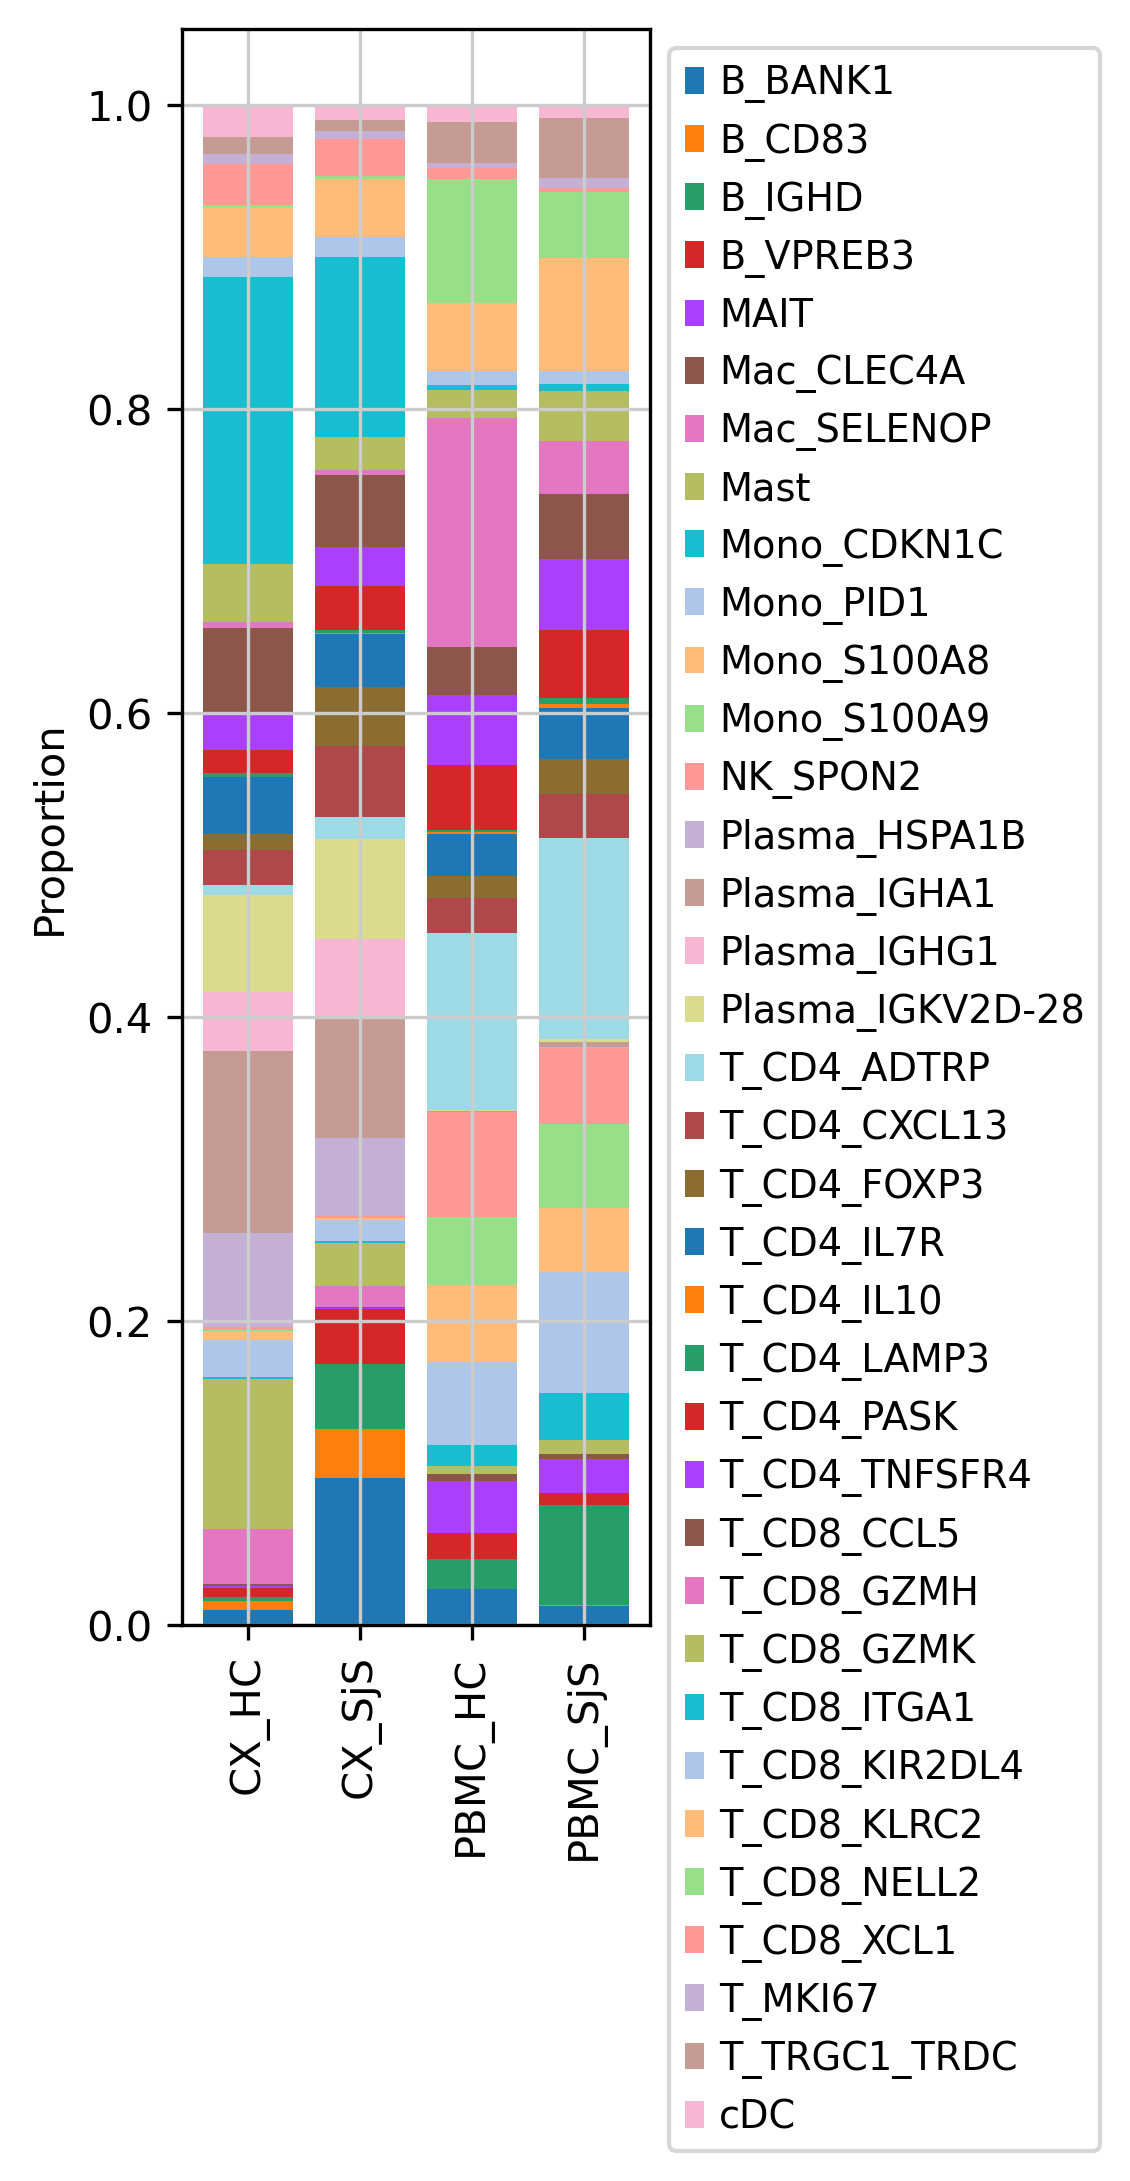

In [17]:
tissue_cli_minor_p_df = plot_proportion(cx_pbmc_immune.obs,obs_x='tissue_cli',obs_y='celltype_minor',obs_x_order=cx_pbmc_immune.obs['tissue_cli'].cat.categories,obs_y_order=cx_pbmc_immune.obs['celltype_minor'].cat.categories,figsize=(2,7))

In [20]:
tissue_cli_minor_p_df['CX_sum'] = tissue_cli_minor_p_df['CX_HC'] + tissue_cli_minor_p_df['CX_SjS']
tissue_cli_minor_p_df['PBMC_sum'] = tissue_cli_minor_p_df['PBMC_HC'] + tissue_cli_minor_p_df['PBMC_SjS']
tissue_cli_minor_p_df['CX_fc'] = np.log2(tissue_cli_minor_p_df['CX_SjS']/tissue_cli_minor_p_df['CX_HC'])
tissue_cli_minor_p_df['PBMC_fc'] = np.log2(tissue_cli_minor_p_df['PBMC_SjS']/tissue_cli_minor_p_df['PBMC_HC'])

tissue_cli_minor_p_df['SjS_sum'] = tissue_cli_minor_p_df['PBMC_SjS'] + tissue_cli_minor_p_df['CX_SjS']
tissue_cli_minor_p_df['HC_sum'] = tissue_cli_minor_p_df['PBMC_HC'] + tissue_cli_minor_p_df['CX_HC']
tissue_cli_minor_p_df['SjS_fc'] = np.log2(tissue_cli_minor_p_df['CX_SjS']/tissue_cli_minor_p_df['PBMC_SjS'])
tissue_cli_minor_p_df['HC_fc'] = np.log2(tissue_cli_minor_p_df['CX_HC']/tissue_cli_minor_p_df['PBMC_HC'])

/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


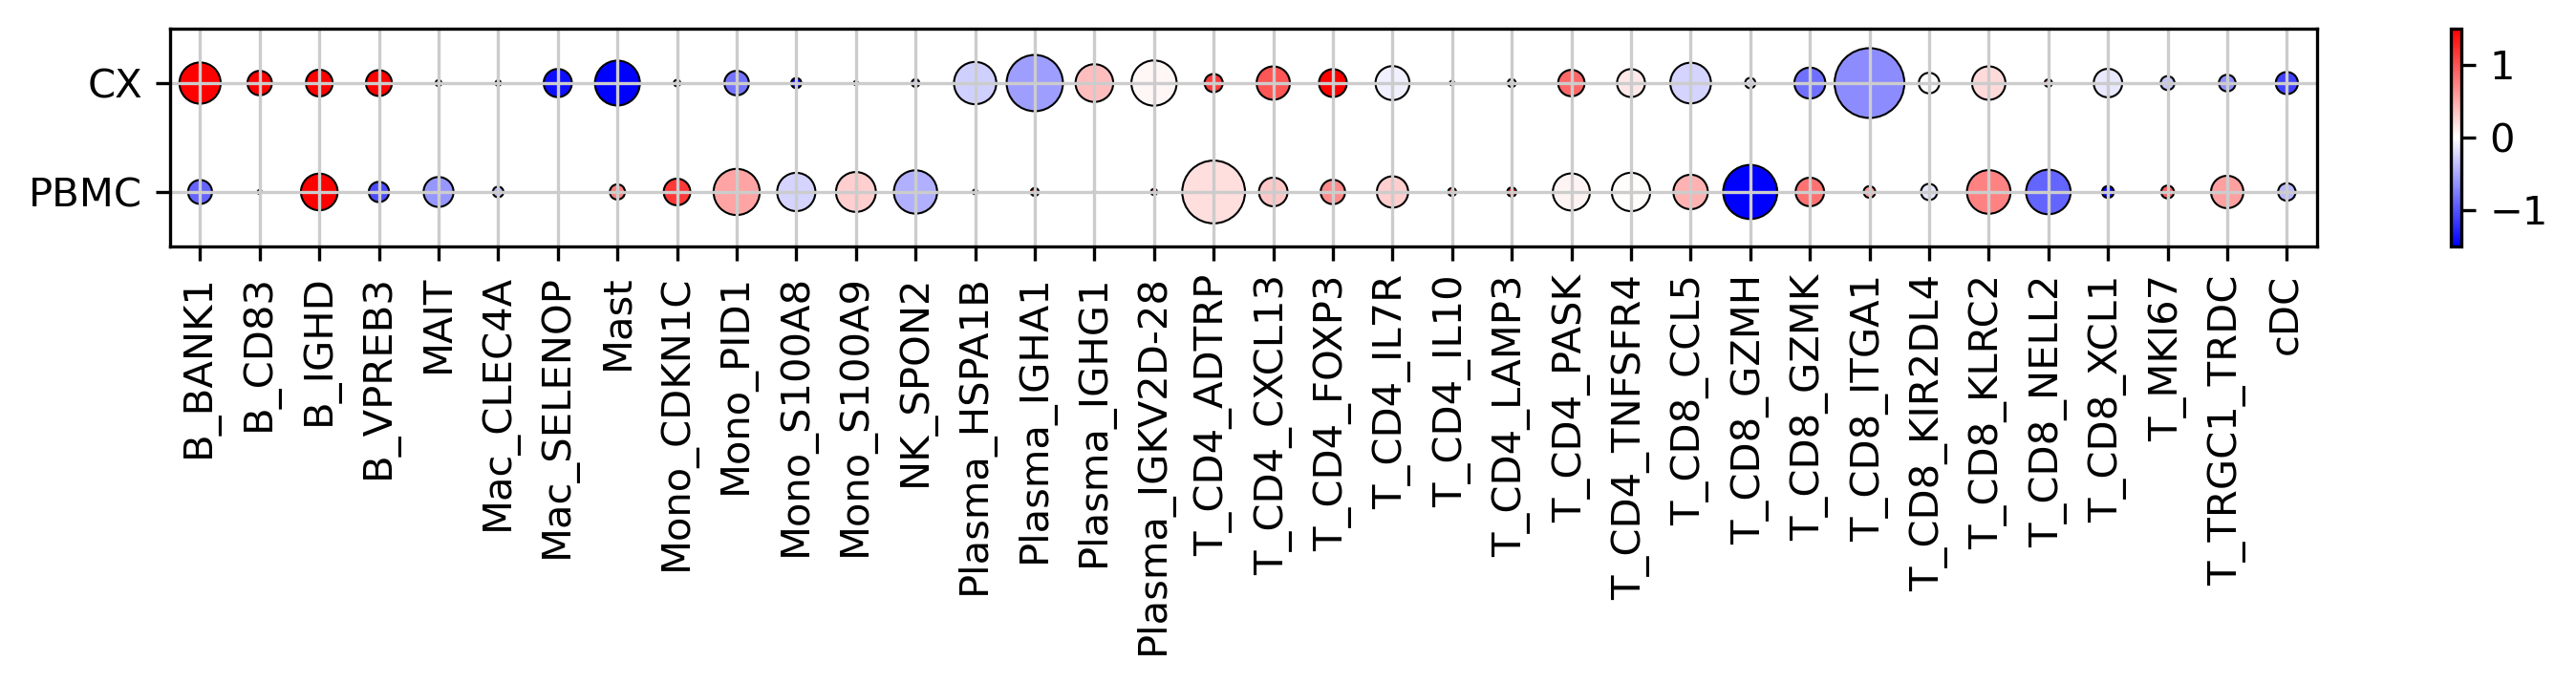

In [21]:
plt.subplots(figsize=(12,1))
plt.scatter(
    x=[list(range(len(tissue_cli_minor_p_df.index)))]*2,
    y=np.repeat(np.arange(2),len((tissue_cli_minor_p_df.index))),
    s=np.array(list(tissue_cli_minor_p_df['PBMC_sum']) + list(tissue_cli_minor_p_df['CX_sum']))*1000,
    c=list(tissue_cli_minor_p_df['PBMC_fc']) + list(tissue_cli_minor_p_df['CX_fc']),
    cmap='bwr',
    edgecolor='black',
    linewidth=0.5,
    vmax=1.5,
    vmin=-1.5
)
plt.yticks([0,1],['PBMC','CX'])
plt.xticks(range(len(tissue_cli_minor_p_df.index)),tissue_cli_minor_p_df.index,rotation=90)
plt.colorbar()
plt.ylim(-0.5,1.5)
plt.xlim(-0.5,len(tissue_cli_minor_p_df.index)-0.5)
plt.show()

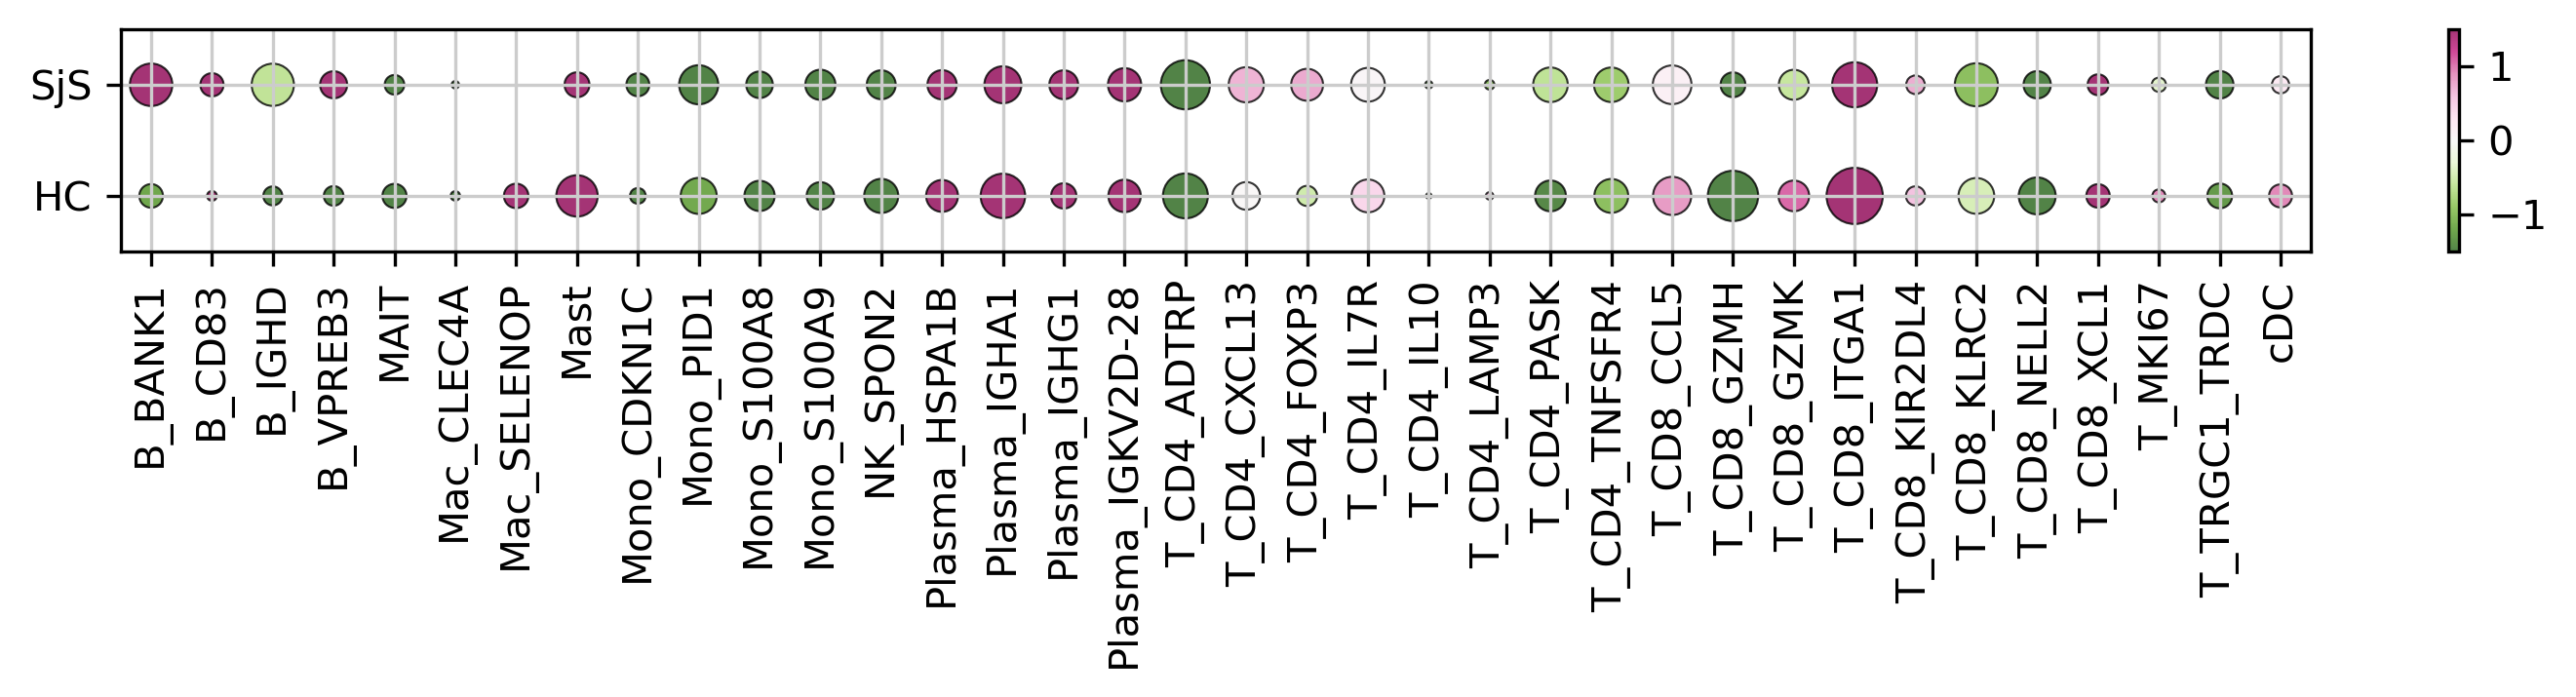

In [22]:
plt.subplots(figsize=(12,1))
plt.scatter(
    x=[list(range(len(tissue_cli_minor_p_df.index)))]*2,
    y=np.repeat(np.arange(2),len((tissue_cli_minor_p_df.index))),
    s=np.array(list(tissue_cli_minor_p_df['HC_sum']) + list(tissue_cli_minor_p_df['SjS_sum']))*1000,
    c=list(tissue_cli_minor_p_df['HC_fc']) + list(tissue_cli_minor_p_df['SjS_fc']),
    cmap='PiYG_r',
    edgecolor='black',
    linewidth=0.5,
    alpha=.8,
    vmax=1.5,
    vmin=-1.5
)
plt.yticks([0,1],['HC','SjS'])
plt.xticks(range(len(tissue_cli_minor_p_df.index)),tissue_cli_minor_p_df.index,rotation=90)
plt.colorbar()
plt.ylim(-0.5,1.5)
plt.xlim(-0.5,len(tissue_cli_minor_p_df.index)-0.5)
plt.show()

In [23]:
from scipy.stats import zscore

In [24]:
tissue_cli_minor_p_df_zs = (tissue_cli_minor_p_df.iloc[:,:4]-np.mean(tissue_cli_minor_p_df.iloc[:,:4].values,keepdims=True,axis=1))/np.std(tissue_cli_minor_p_df.iloc[:,:4].values,keepdims=True,axis=1)

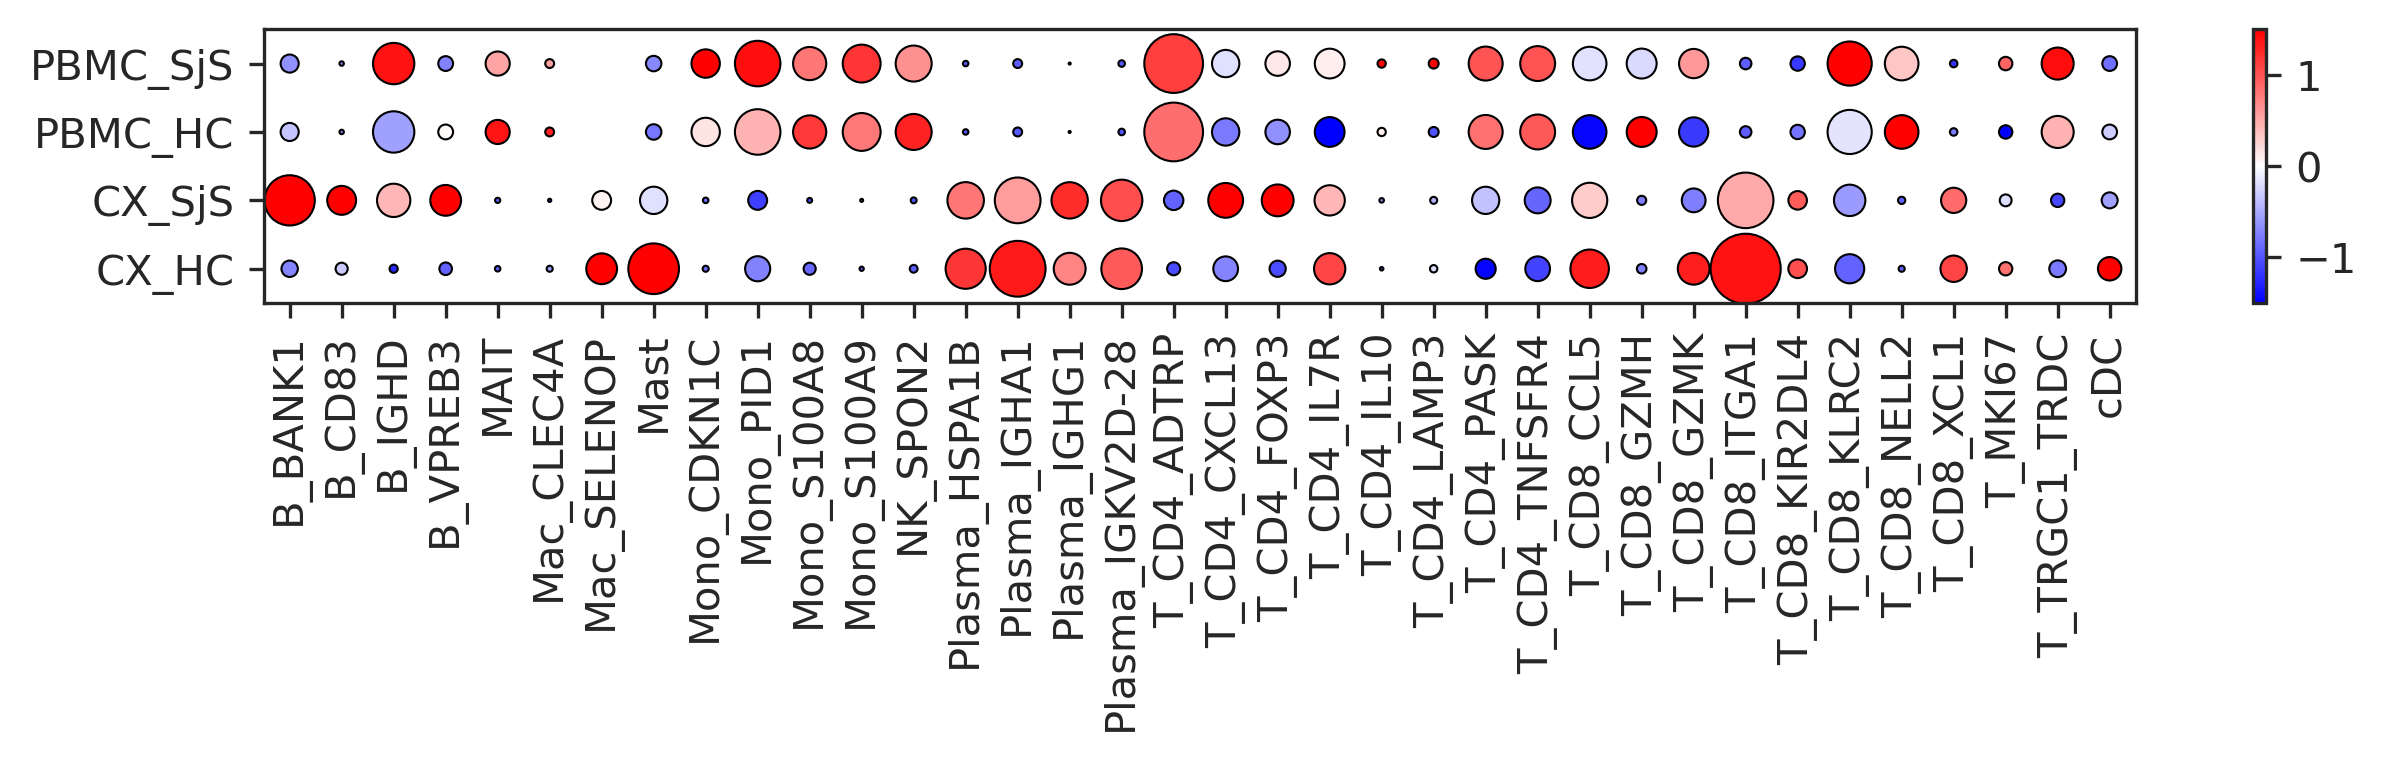

In [25]:
sns.set_style('ticks')
plt.subplots(figsize=(10,1.2))
plt.scatter(
    x=[list(range(len(tissue_cli_minor_p_df_zs.index)))]*4,
    y=np.repeat(np.arange(4),len((tissue_cli_minor_p_df_zs.index))),
    s=np.array(list(tissue_cli_minor_p_df['CX_HC'])+list(tissue_cli_minor_p_df['CX_SjS'])+list(tissue_cli_minor_p_df['PBMC_SjS'])+list(tissue_cli_minor_p_df['PBMC_SjS']))*1500,
    c=list(list(tissue_cli_minor_p_df_zs['CX_HC'])+list(tissue_cli_minor_p_df_zs['CX_SjS'])+list(tissue_cli_minor_p_df_zs['PBMC_HC'])+list(tissue_cli_minor_p_df_zs['PBMC_SjS'])),
    cmap='bwr',
    edgecolor='black',
    linewidth=0.5,
    vmax=1.5,
    vmin=-1.5
)
plt.yticks([0,1,2,3],tissue_cli_minor_p_df_zs.columns)
plt.xticks(range(len(tissue_cli_minor_p_df_zs.index)),tissue_cli_minor_p_df_zs.index,rotation=90)
plt.colorbar()
plt.ylim(-0.5,len(tissue_cli_minor_p_df_zs.columns)-0.5)
plt.xlim(-0.5,len(tissue_cli_minor_p_df_zs.index)-0.5)
plt.show()

In [9]:
def filter_degs_df(cli_state_df):
    cli_state_logfc = pd.DataFrame(index=cli_state_df.celltype_minor.unique(),columns=cli_state_df.names.unique())
    cli_state_pval = pd.DataFrame(index=cli_state_df.celltype_minor.unique(),columns=cli_state_df.names.unique())
    cli_state_pts = pd.DataFrame(index=cli_state_df.celltype_minor.unique(),columns=cli_state_df.names.unique())
    cli_state_scores = pd.DataFrame(index=cli_state_df.celltype_minor.unique(),columns=cli_state_df.names.unique())
    for c in cli_state_df.celltype_minor.unique():
        cli_state_df_tmp = cli_state_df[cli_state_df.celltype_minor == c]
        cli_state_logfc.loc[c,cli_state_df_tmp.names] = cli_state_df_tmp.logfoldchanges.values
        cli_state_pval.loc[c,cli_state_df_tmp.names] = cli_state_df_tmp.pvals_adj.values
        cli_state_pts.loc[c,cli_state_df_tmp.names] = cli_state_df_tmp.pct_nz_group.values
        cli_state_scores.loc[c,cli_state_df_tmp.names] = cli_state_df_tmp.scores.values
    cli_state_logfc = cli_state_logfc.fillna(0)
    cli_state_pval = cli_state_pval.fillna(0)
    cli_state_pts = cli_state_pts.fillna(0)
    cli_state_scores = cli_state_scores.fillna(0)
    cli_state_up_logfc = cli_state_logfc.loc[:,(((cli_state_pts.values > 0.1)&(cli_state_logfc.values > 0.5)&(cli_state_pval.values < 0.01)).sum(0) != 0)]
    cli_state_down_logfc = cli_state_logfc.loc[:,(((cli_state_pts.values > 0.1)&(cli_state_logfc.values < -0.5)&(cli_state_pval.values < 0.01)).sum(0) != 0)]
    cli_state_all_logfc = cli_state_logfc.loc[:,(((cli_state_pts.values > 0.1)&((cli_state_logfc.values < -0.5)|(cli_state_logfc.values > 0.5))&(cli_state_pval.values < 0.01)).sum(0) != 0)]
    cli_state_all_pval = cli_state_pval.loc[:,(((cli_state_pts.values > 0.1)&((cli_state_logfc.values < -0.5)|(cli_state_logfc.values > 0.5))&(cli_state_pval.values < 0.01)).sum(0) != 0)]
    # cli_state_all_pval = cli_state_all_pval*cli_state_mask
    return cli_state_all_pval, cli_state_all_logfc
    # return cli_state_all_pval

In [10]:
pbmc_immune_cli_state_df = []
for c in cx_pbmc_immune.obs.celltype_minor.unique():
    if cx_pbmc_immune[(cx_pbmc_immune.obs.celltype_minor==c)&(cx_pbmc_immune.obs.tissue=='PBMC')&(cx_pbmc_immune.obs.cli_state=='SjS')].shape[0] > 1:
        pbmc_immune_ctmp = cx_pbmc_immune[(cx_pbmc_immune.obs.celltype_minor==c)&(cx_pbmc_immune.obs.tissue=='PBMC')].copy()
        sc.tl.rank_genes_groups(pbmc_immune_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
        pbmc_immune_ctmp_df = sc.get.rank_genes_groups_df(pbmc_immune_ctmp,group='SjS',key=f'{c}_cli')
        pbmc_immune_ctmp_df['celltype_minor'] = c
        pbmc_immune_cli_state_df.append(pbmc_immune_ctmp_df)
    else:
        print('skip: ',c)
pbmc_immune_cli_state_df = pd.concat(pbmc_immune_cli_state_df,axis=0)

cx_immune_cli_state_df = []
for c in cx_pbmc_immune.obs.celltype_minor.unique():
    if (cx_pbmc_immune[(cx_pbmc_immune.obs.celltype_minor==c)&(cx_pbmc_immune.obs.tissue=='CX')&(cx_pbmc_immune.obs.cli_state=='SjS')].shape[0] > 1) and cx_pbmc_immune[(cx_pbmc_immune.obs.celltype_minor==c)&(cx_pbmc_immune.obs.tissue=='CX')&(cx_pbmc_immune.obs.cli_state=='HC')].shape[0] > 1:
        cx_immune_ctmp = cx_pbmc_immune[(cx_pbmc_immune.obs.celltype_minor==c)&(cx_pbmc_immune.obs.tissue=='CX')].copy()
        sc.tl.rank_genes_groups(cx_immune_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
        cx_immune_ctmp_df = sc.get.rank_genes_groups_df(cx_immune_ctmp,group='SjS',key=f'{c}_cli')
        cx_immune_ctmp_df['celltype_minor'] = c
        cx_immune_cli_state_df.append(cx_immune_ctmp_df)
    else:
        print('skip: ',c)
cx_immune_cli_state_df = pd.concat(cx_immune_cli_state_df,axis=0)

ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_IGKV2D-28_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_IGHA1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_ADTRP_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_MKI67_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_IGHG1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mast_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
skip:  Mac_SELENOP
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_PID1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['cDC_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_CDKN1C_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_ITGA1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_BANK1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_CXCL13_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_FOXP3_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_VPREB3_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_S100A8_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_CD83_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_PASK_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_TNFSFR4_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_IL7R_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_XCL1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_CCL5_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_KIR2DL4_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_KLRC2_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_TRGC1_TRDC_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_IGHD_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_LAMP3_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_GZMK_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_HSPA1B_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_GZMH_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['MAIT_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['NK_SPON2_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_NELL2_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_IL10_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mac_CLEC4A_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_S100A9_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_IGKV2D-28_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_IGHA1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_ADTRP_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_MKI67_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_IGHG1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mast_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mac_SELENOP_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_PID1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['cDC_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_CDKN1C_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_ITGA1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_BANK1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_CXCL13_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_FOXP3_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_VPREB3_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_S100A8_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_CD83_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_PASK_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_TNFSFR4_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_IL7R_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_XCL1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_CCL5_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_KIR2DL4_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_KLRC2_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_TRGC1_TRDC_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['B_IGHD_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_LAMP3_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_GZMK_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Plasma_HSPA1B_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_GZMH_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['MAIT_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['NK_SPON2_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD8_NELL2_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['T_CD4_IL10_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mac_CLEC4A_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'orig.ident' as categorical
... storing 'ident' as categorical
... storing 'scDblFinder.sample' as categorical
... storing 'scDblFinder.class' as categorical
... storing 'sample' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'celltype_submarkers' as categorical
... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.5' as categorical
... storing 'tissue' as categorical
... storing 'RNA_snn_res.0.5' as categorical


    finished: added to `.uns['Mono_S100A9_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [11]:
pbmc_immune_cli_state_df

names     scores  logfoldchanges          pvals      pvals_adj  \
0        LY6E   4.698525        3.627770   2.620474e-06   9.591196e-02   
1        MT2A   4.079932        4.578707   4.504887e-05   5.496112e-01   
2       RPL13   3.947873        0.626324   7.884864e-05   7.214848e-01   
3      TMSB4X   3.878368        0.673542   1.051595e-04   7.697887e-01   
4       RPL36   3.655953        0.463477   2.562286e-04   1.000000e+00   
...       ...        ...             ...            ...            ...   
36596   RPS4X -28.703924       -0.733297  3.408394e-181  8.910758e-178   
36597   RPS24 -29.746588       -0.535831  1.919658e-194  6.387400e-191   
36598   RPL10 -32.840469       -0.713148  1.558225e-236  8.147512e-233   
36599    RPS8 -33.315472       -0.773484  2.305132e-243  1.406169e-239   
36600   RPLP1 -34.465885       -0.855565  2.603509e-260  1.905820e-256   

       pct_nz_group  pct_nz_reference    celltype_minor  
0          0.900000          0.222222  Plasma_IGKV2D-28  
1          0.700000          0.055556  Plasma_IGKV2D-28  
2          1.000000          1.000000  Plasma_IGKV2D-28  
3          1.000000          1.000000  Plasma_IGKV2D-28  
4          0.980000          1.000000  Plasma_IGKV2D-28  
...             ...               ...               ...  
36596      0.998803          1.000000       Mono_S100A9  
36597      1.000000          1.000000       Mono_S100A9  
36598      1.000000          1.000000       Mono_S100A9  
36599      1.000000          1.000000       Mono_S100A9  
36600      1.000000          1.000000       Mono_S100A9  

[1281035 rows x 8 columns]

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


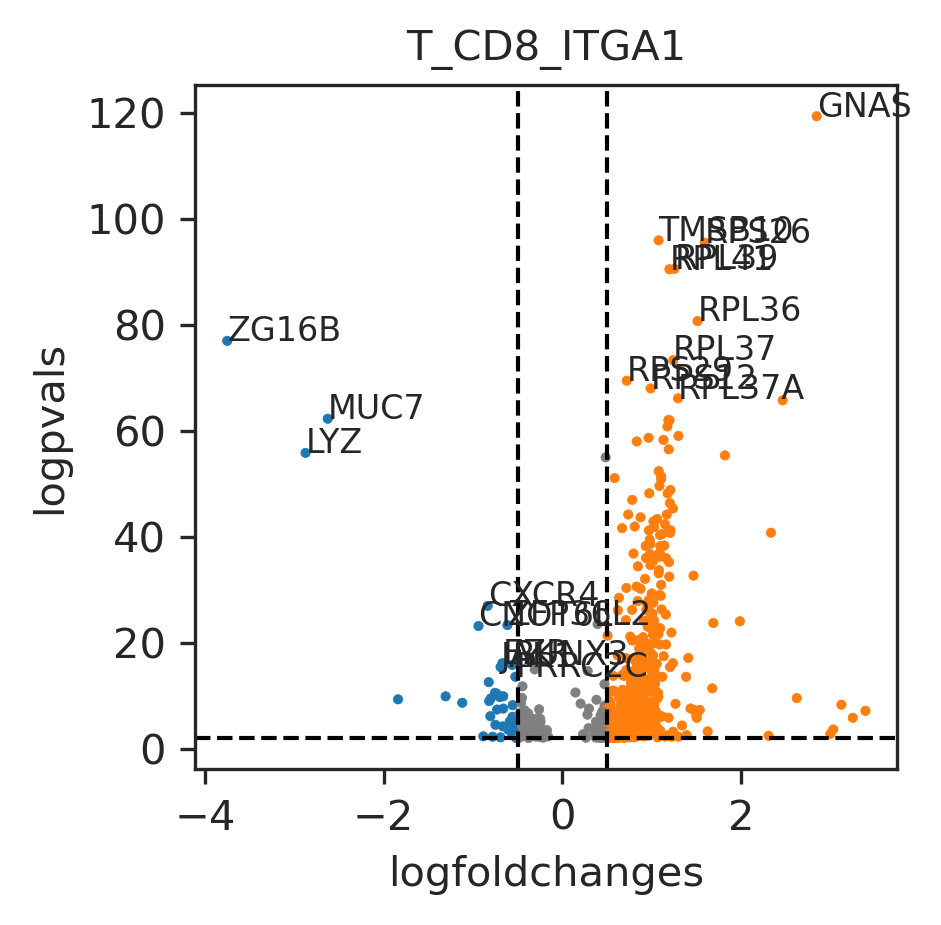

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


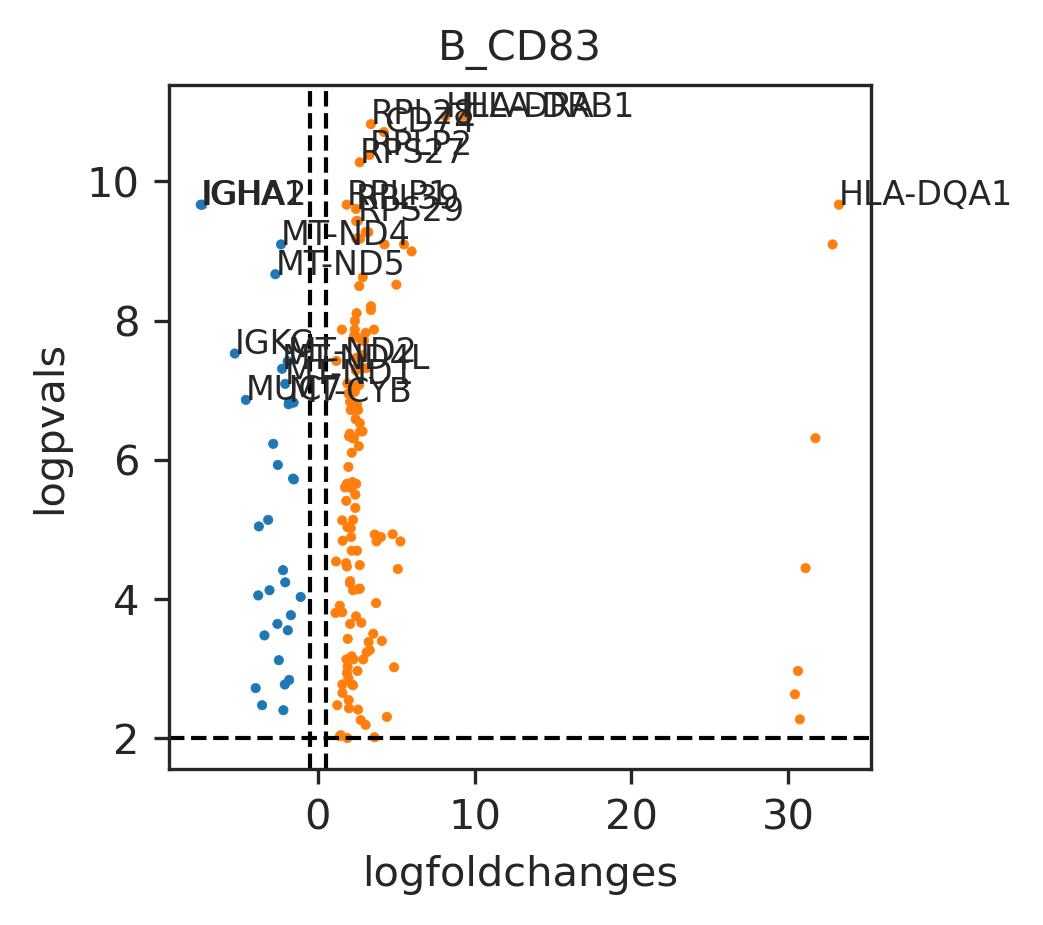

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


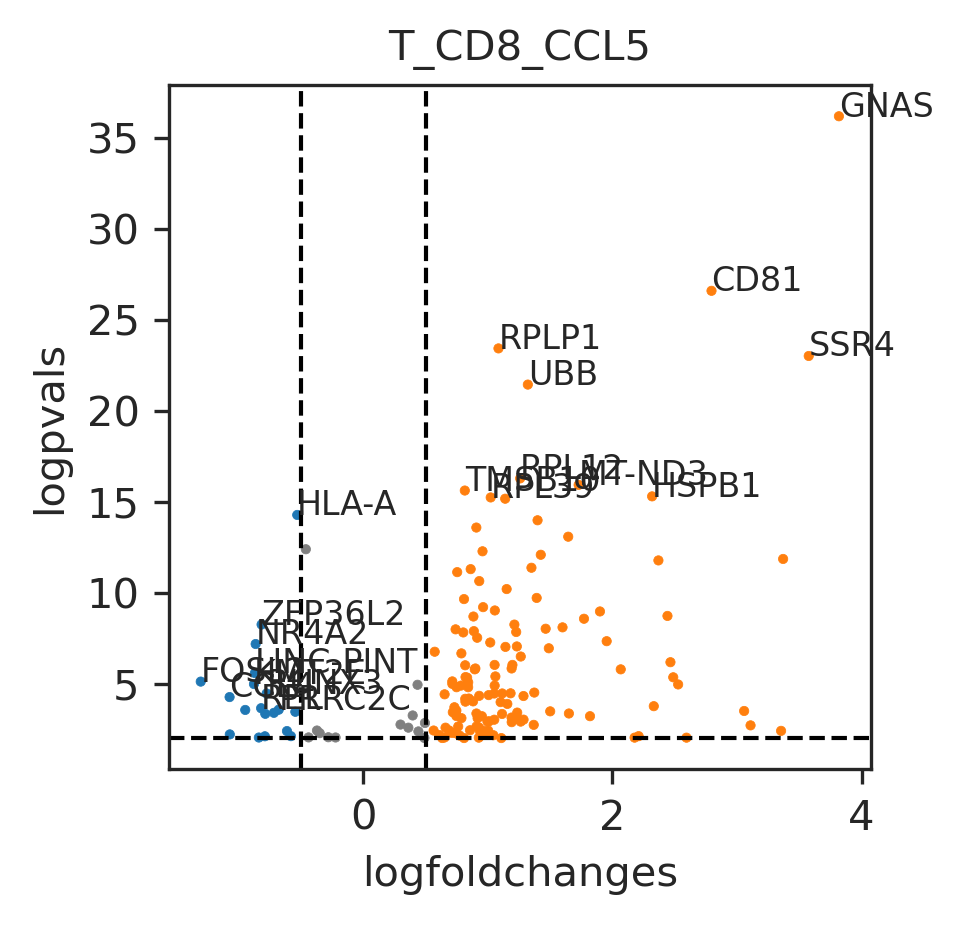

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


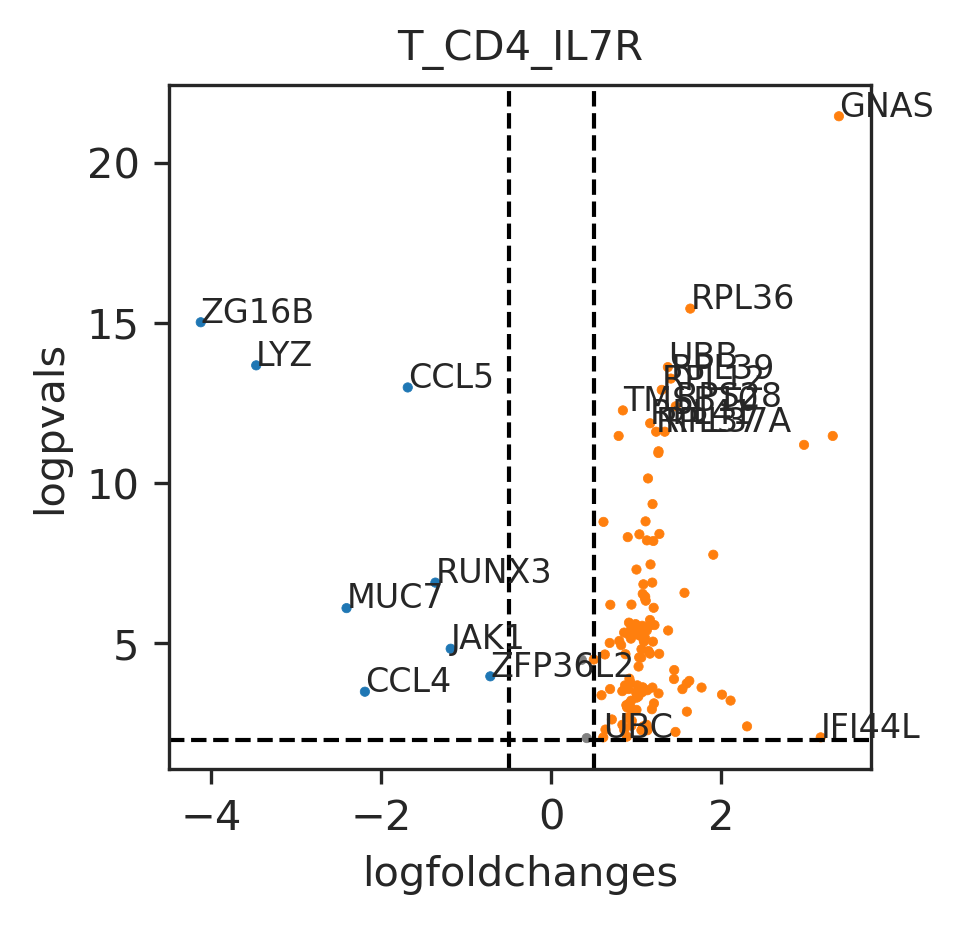

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


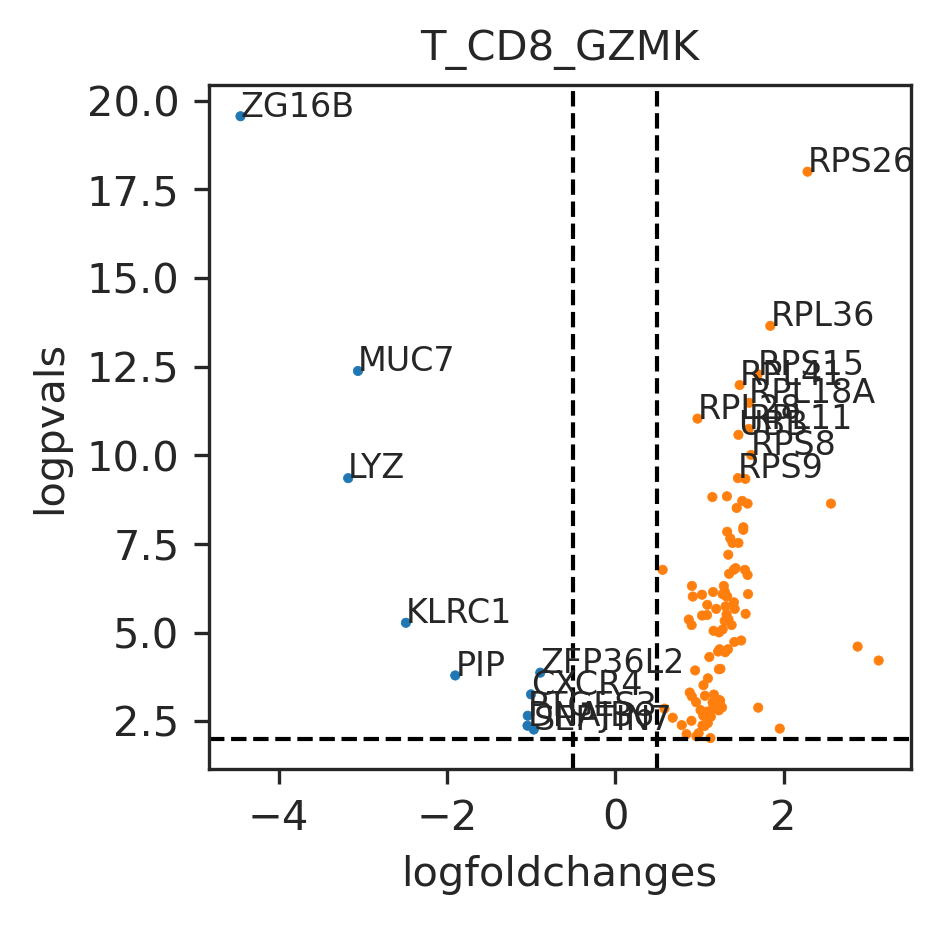

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


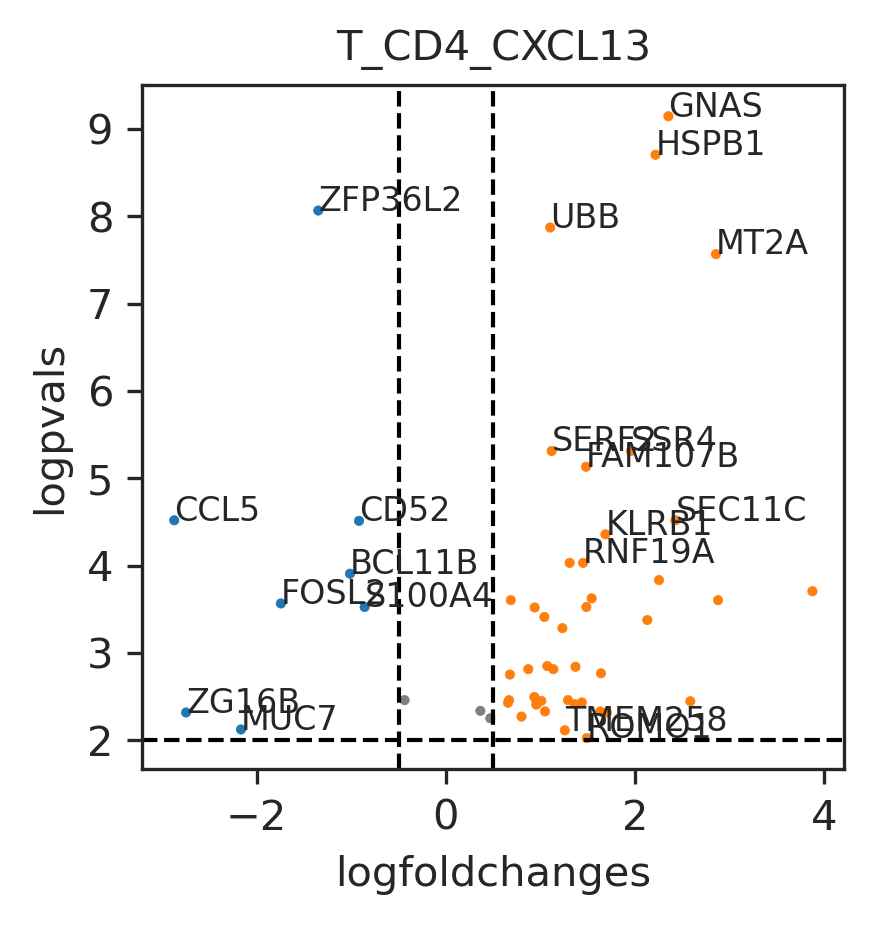

<ipython-input-38-db854ec21b9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


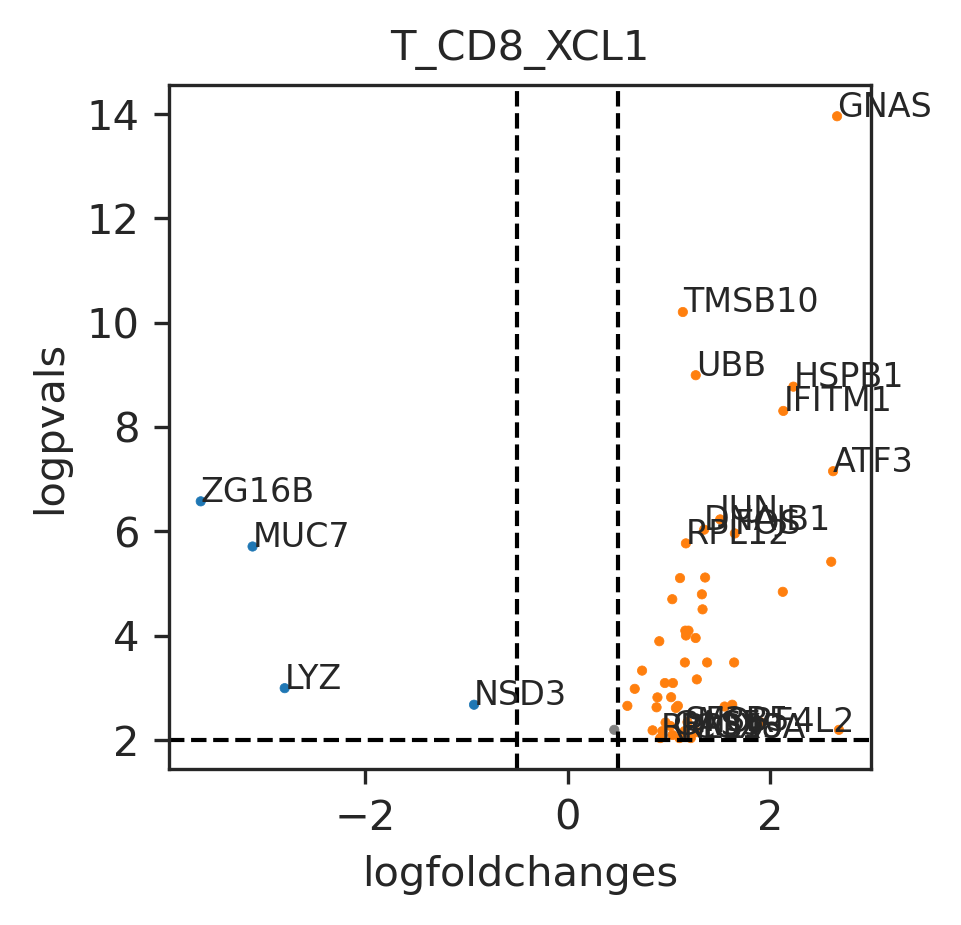

In [38]:
sns.set_style('ticks')
for celltype in ['T_CD8_ITGA1','B_CD83','T_CD8_CCL5','T_CD4_IL7R','T_CD8_GZMK','T_CD4_CXCL13','T_CD8_XCL1']:
    tmp_cli_state_degs = cx_immune_cli_state_df[cx_immune_cli_state_df.celltype_minor == celltype]
    tmp_cli_state_degs['logpvals'] = -np.log10(tmp_cli_state_degs['pvals_adj'])
    tmp_cli_state_degs.loc[tmp_cli_state_degs['logpvals'] == np.inf,'logpvals'] = 300
    tmp_cli_state_degs = tmp_cli_state_degs[tmp_cli_state_degs['pct_nz_group'] > 0.1]
    tmp_cli_state_degs = tmp_cli_state_degs[tmp_cli_state_degs['pvals_adj'] < 0.01]
    tmp_cli_state_degs['color'] = '#808080'
    tmp_cli_state_degs.loc[(tmp_cli_state_degs['logfoldchanges'] >= 0.5)&((tmp_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[1])
    tmp_cli_state_degs.loc[(tmp_cli_state_degs['logfoldchanges'] <= -0.5)&((tmp_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[0])
    sns.scatterplot(x=tmp_cli_state_degs['logfoldchanges'],y=tmp_cli_state_degs['logpvals'],c=tmp_cli_state_degs['color'].values,edgecolor=None,s=5)
    plt.axvline(x=0.5,linewidth=1,linestyle='--',color='black')
    plt.axvline(x=-0.5,linewidth=1,linestyle='--',color='black')
    plt.axhline(y=2,linewidth=1,linestyle='--',color='black')
    plt.title(celltype)
    for ind in tmp_cli_state_degs.loc[(np.abs(tmp_cli_state_degs['logfoldchanges']) >= 0.5)&((tmp_cli_state_degs['pvals_adj'] < 0.01)),:].head(10).index:
        plt.text(x=tmp_cli_state_degs.loc[ind,'logfoldchanges'],y=tmp_cli_state_degs.loc[ind,'logpvals'],s=tmp_cli_state_degs.loc[ind,'names'],fontsize=8)
    for ind in tmp_cli_state_degs.loc[(np.abs(tmp_cli_state_degs['logfoldchanges']) >= 0.5)&((tmp_cli_state_degs['pvals_adj'] < 0.01)),:].tail(10).index:
        plt.text(x=tmp_cli_state_degs.loc[ind,'logfoldchanges'],y=tmp_cli_state_degs.loc[ind,'logpvals'],s=tmp_cli_state_degs.loc[ind,'names'],fontsize=8)
    plt.savefig(f'figures/vocanoplot_scatterplot_cx_immune_{celltype}_vocanoplot.pdf',bbox_inches='tight')
    plt.show()

In [12]:
pbmc_immune_cli_state_df_filtered = pbmc_immune_cli_state_df[(pbmc_immune_cli_state_df.pvals_adj < 0.01) & (pbmc_immune_cli_state_df.pct_nz_group > 0.1) & (pbmc_immune_cli_state_df.logfoldchanges > 0.5)]
pbmc_immune_cli_state_df_filtered = pbmc_immune_cli_state_df_filtered.reset_index(drop=True)
pbmc_immune_cli_state_df_filtered['tissue_celltype'] = ['pbmc_'+pbmc_immune_cli_state_df_filtered['celltype_minor'][i] for i in range(len(pbmc_immune_cli_state_df_filtered))]
cx_immune_cli_state_df_filtered = cx_immune_cli_state_df[(cx_immune_cli_state_df.pvals_adj < 0.01) & (cx_immune_cli_state_df.pct_nz_group > 0.1) & (cx_immune_cli_state_df.logfoldchanges > 0.5)]
cx_immune_cli_state_df_filtered = cx_immune_cli_state_df_filtered.reset_index(drop=True)
cx_immune_cli_state_df_filtered['tissue_celltype'] = ['cx_'+cx_immune_cli_state_df_filtered['celltype_minor'][i] for i in range(len(cx_immune_cli_state_df_filtered))]

In [14]:
pbmc_cx_immune_cli_state_df_filtered = pd.concat([pbmc_immune_cli_state_df_filtered,cx_immune_cli_state_df_filtered],axis=0)
pbmc_cx_immune_cli_state_df_filtered = pbmc_cx_immune_cli_state_df_filtered.reset_index(drop=True)

In [15]:
pbmc_cx_immune_cli_state_df_filtered.to_csv('source_data/source_data_sfig5e&f.csv')

In [34]:
degs_proportion = []
for c in pbmc_cx_immune_cli_state_df_filtered.celltype_minor.unique():
    cx_tmp_degs = pbmc_cx_immune_cli_state_df_filtered[pbmc_cx_immune_cli_state_df_filtered.tissue_celltype == 'cx_'+c].names.unique()
    pbmc_tmp_degs = pbmc_cx_immune_cli_state_df_filtered[pbmc_cx_immune_cli_state_df_filtered.tissue_celltype == 'pbmc_'+c].names.unique()
    degs_proportion.append([len(np.intersect1d(cx_tmp_degs,pbmc_tmp_degs)),len(np.setdiff1d(cx_tmp_degs,pbmc_tmp_degs)),len(np.setdiff1d(pbmc_tmp_degs,cx_tmp_degs)),len(np.union1d(pbmc_tmp_degs,cx_tmp_degs))])
degs_proportion = np.array(degs_proportion,dtype=np.float32)

In [35]:
order = np.argsort(-(degs_proportion[:,0]+degs_proportion[:,1]))

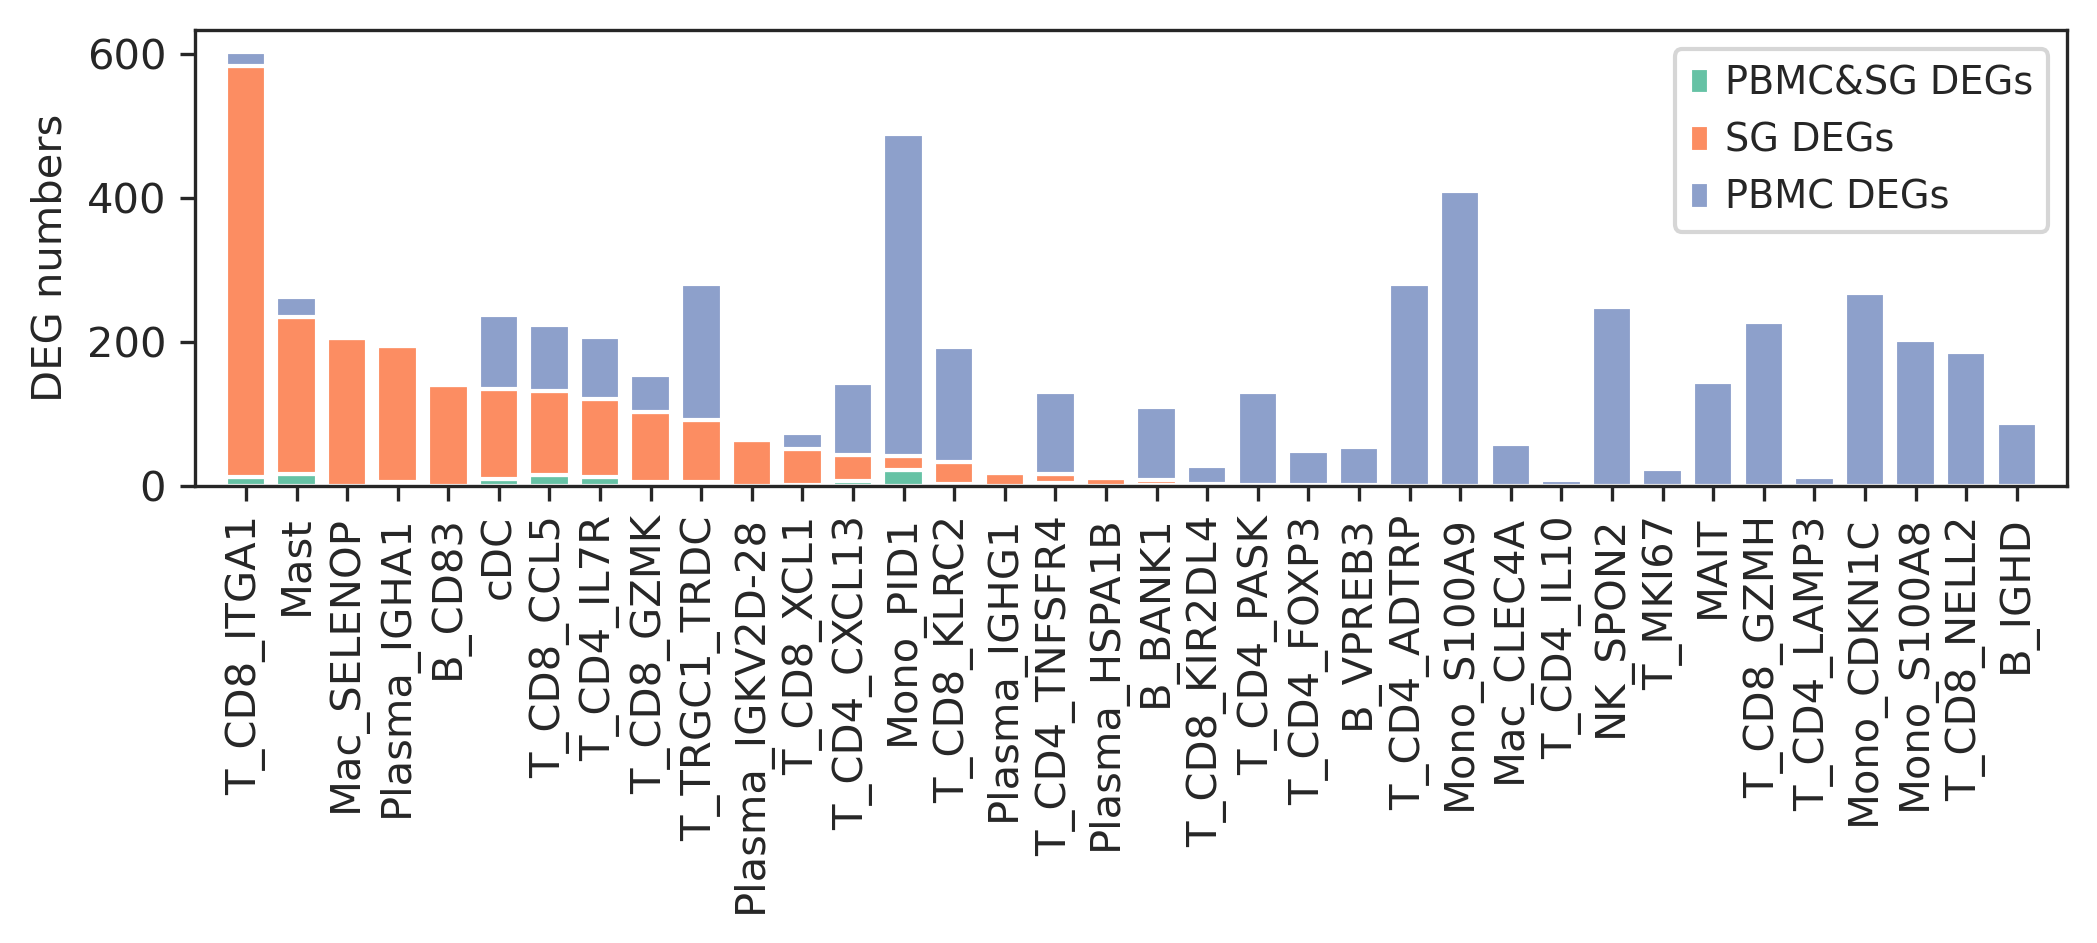

In [36]:
fig,ax=plt.subplots(figsize=(8,2))
sns.set_style('ticks')
colors = sns.color_palette('Set2',n_colors=3)
plt.bar(x=np.arange(degs_proportion.shape[0]),height=degs_proportion[:,0][order],color=colors[0],label='PBMC&SG DEGs')
plt.bar(x=np.arange(degs_proportion.shape[0]),height=degs_proportion[:,1][order],bottom = degs_proportion[:,:1].sum(axis=1)[order],color=colors[1],label='SG DEGs')
plt.bar(x=np.arange(degs_proportion.shape[0]),height=degs_proportion[:,2][order],bottom = degs_proportion[:,:2].sum(axis=1)[order],color=colors[2],label='PBMC DEGs')
plt.legend(bbox_to_anchor=(1,1))
plt.xlim(-1,36)
plt.xticks(np.arange(degs_proportion.shape[0]),pbmc_cx_immune_cli_state_df_filtered.celltype_minor.unique()[order],rotation=90)
plt.ylabel('DEG numbers')
plt.show()